# Clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Caricamento del dataset
df = pd.read_csv('../Datasets/atp_tennis.csv')

# Pre-elaborazione
# Rimuovere righe con valori mancanti (se presenti)
df = df.dropna()

Prima di eseguire il clustering, dobbiamo raccogliere le feature dai dati delle partite di tennis, seguendo i seguenti passaggi:

1.	Durata della partita:

    Anche se il tuo dataset non include un campo che indichi la durata della partita, possiamo calcolare una metrica equivalente. Possiamo utilizzare il numero di set giocati o la differenza nei punteggi come indicatore della durata della partita.

2.	Numero di partite giocate (total_games_played):

    Calcoliamo il numero di partite giocate per ogni giocatore. Questo si può ottenere contando il numero di righe in cui il giocatore compare come Player_1 o Player_2 nel dataset.

3.	Punteggi totali (total_points):

    Sommiamo i punteggi di un giocatore da ogni partita. Per esempio, possiamo sommare Pts_1 per il giocatore Player_1 e Pts_2 per Player_2 per ottenere un totale di punti per ogni giocatore.

4.	Numero di tornei a cui un giocatore ha partecipato (n_tournaments):

    Questo può essere calcolato contando i tornei distinti a cui un giocatore ha partecipato. Ad esempio, possiamo ottenere il numero di tornei unici tramite il campo Tournament.

5.	Numero di finali giocate (total_final_matches):

    Per calcolare questo, possiamo filtrare le partite in cui un giocatore ha partecipato alla finale (questo potrebbe richiedere una colonna aggiuntiva per identificare la fase del torneo).

6.	Numero di vittorie (total_wins):

    Il numero di vittorie totali di un giocatore può essere calcolato contando il numero di volte che un giocatore appare come Winner nel dataset.

7.	Superficie di gioco (surface):

    Può essere utile come feature categorica, come nel caso dei calciatori con le superfici di gioco (Hard, Grass, Clay), che può influire sul gioco di un tennista.

In [3]:
# 1. Calcolare il numero di partite giocate per ogni giocatore
total_games_player_1 = df.groupby('Player_1').size()
total_games_player_2 = df.groupby('Player_2').size()

# Uniamo i due gruppi per ottenere il numero totale di partite giocate per ogni giocatore
total_games = total_games_player_1.add(total_games_player_2, fill_value=0)

# 2. Calcolare le vittorie per superficie per ogni giocatore
surface_wins = df.groupby(['Winner', 'Surface']).size().unstack(fill_value=0)

# Sommiamo i punteggi per ottenere il totale di punti
#total_points = total_points_player_1.add(total_points_player_2, fill_value=0)

# 3. Calcolare il numero di tornei per ogni giocatore
tournaments_player_1 = df.groupby('Player_1')['Tournament'].nunique()
tournaments_player_2 = df.groupby('Player_2')['Tournament'].nunique()
total_tournaments = tournaments_player_1.add(tournaments_player_2, fill_value=0)

# 4. Calcolare il numero di finali giocate
finals_player_1 = df[df['Round'] == 'The Final'].groupby('Player_1').size()
finals_player_2 = df[df['Round'] == 'The Final'].groupby('Player_2').size()
total_finals = finals_player_1.add(finals_player_2, fill_value=0)

# 5. Numero di vittorie (ogni volta che un giocatore appare come Winner)
total_wins = df.groupby('Winner').size()

# 6. Calcolare il miglior ranking raggiunto
best_rank_1 = df.groupby('Player_1')['Rank_1'].min()
best_rank_2 = df.groupby('Player_2')['Rank_2'].min()
best_rank = best_rank_1.combine_first(best_rank_2)

# Creare il DataFrame finale con tutte le statistiche
player_stats = pd.DataFrame({
    'total_matches': total_games,
    'total_tournaments': total_tournaments,
    'total_finals': total_finals,
    'total_wins': total_wins,
    'best_rank': best_rank
})

# Aggiungere le colonne per le vittorie su ogni superficie
for surface in surface_wins.columns:
    player_stats[f'wins_{surface.lower()}'] = surface_wins[surface]

# 7. Gestire i valori NaN e Inf
# Pulizia dei dati
player_stats = player_stats.fillna(0)
player_stats = player_stats.replace([np.inf, -np.inf], 0)

# Salvare il DataFrame in un file CSV
player_stats.to_csv('../Datasets/tennis_player_stats_for_clustering.csv')

# Per verificare che il DataFrame sia stato salvato correttamente
print("\nDimensioni del DataFrame salvato:", player_stats.shape)
print("\nPrime righe del DataFrame:")
print(player_stats.head())

# Mostrare i top 10 giocatori per numero di vittorie
print("Top 10 giocatori per numero di vittorie:")
print(player_stats.sort_values('total_wins', ascending=False).head(10))


Dimensioni del DataFrame salvato: (1358, 8)

Prime righe del DataFrame:
               total_matches  total_tournaments  total_finals  total_wins  \
 Hajek J.                2.0                1.0           0.0         1.0   
Acasuso J.             192.0               68.0           5.0       101.0   
Adaktusson J.            1.0                1.0           0.0         0.0   
Agamenone F.             5.0                2.0           0.0         3.0   
Agassi A.               37.0               17.0           3.0        26.0   

               best_rank  wins_clay  wins_grass  wins_hard  
 Hajek J.           79.0        1.0         0.0        0.0  
Acasuso J.          20.0       67.0         0.0       34.0  
Adaktusson J.      265.0        0.0         0.0        0.0  
Agamenone F.       156.0        3.0         0.0        0.0  
Agassi A.            6.0        0.0         2.0       24.0  
Top 10 giocatori per numero di vittorie:
             total_matches  total_tournaments  total_fina

Filtriamo i tennisti che hanno vinto almeno una volta in carriera

In [4]:
# Calcolare il numero di tennisti con almeno una vittoria
vincitori = player_stats[player_stats['total_wins'] > 0]
non_vincitori = player_stats[player_stats['total_wins'] == 0]

print(f"Numero di tennisti che hanno vinto almeno una volta: {len(vincitori)}")
print(f"Numero di tennisti che non hanno mai vinto: {len(non_vincitori)}")

# Mostrare la percentuale
totale_tennisti = len(player_stats)
percentuale_vincitori = (len(vincitori) / totale_tennisti) * 100
percentuale_non_vincitori = (len(non_vincitori) / totale_tennisti) * 100

print(f"\nPercentuale vincitori: {percentuale_vincitori:.2f}%")
print(f"Percentuale non vincitori: {percentuale_non_vincitori:.2f}%")

Numero di tennisti che hanno vinto almeno una volta: 901
Numero di tennisti che non hanno mai vinto: 457

Percentuale vincitori: 66.35%
Percentuale non vincitori: 33.65%


In [5]:
# Filtrare i tennisti che hanno vinto almeno una volta in carriera
vincitori = player_stats[player_stats['total_wins'] > 0].sort_values('total_wins', ascending=False)

print("Statistiche dei tennisti con almeno una vittoria:")
print(vincitori)

# Statistiche aggiuntive sui vincitori
print(f"\nNumero totale di vincitori: {len(vincitori)}")
print("\nStatistiche riassuntive delle vittorie:")
print(vincitori['total_wins'].describe())

Statistiche dei tennisti con almeno una vittoria:
                    total_matches  total_tournaments  total_finals  \
Djokovic N.                1201.0               98.0         136.0   
Nadal R.                   1096.0              100.0         119.0   
Federer R.                  979.0               73.0         115.0   
Murray A.                   917.0              138.0          67.0   
Ferrer D.                   874.0              140.0          48.0   
...                           ...                ...           ...   
Matsukevitch D.               4.0                4.0           0.0   
Matsui T.                     3.0                3.0           0.0   
Masur D.                      6.0                5.0           0.0   
Mamiit C.                     3.0                2.0           0.0   
van Scheppingen D.            2.0                2.0           0.0   

                    total_wins  best_rank  wins_clay  wins_grass  wins_hard  
Djokovic N.             1016.0 

## Visualizzazione dei dati tramite distribuzioni e grafici

### Come sono distribuite le vittorie tra i giocatori?

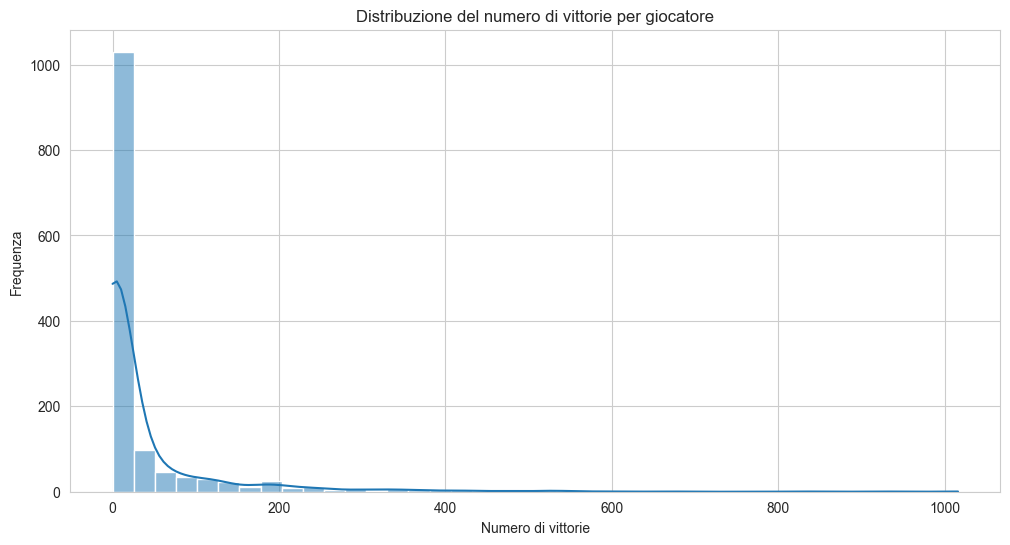

In [6]:
# TUTTI I GIOCATORI

# 1. Distribuzione del numero di vittorie
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.histplot(data=player_stats['total_wins'], kde=True, bins=40)
plt.title('Distribuzione del numero di vittorie per giocatore')
plt.xlabel('Numero di vittorie')
plt.ylabel('Frequenza')
plt.show()

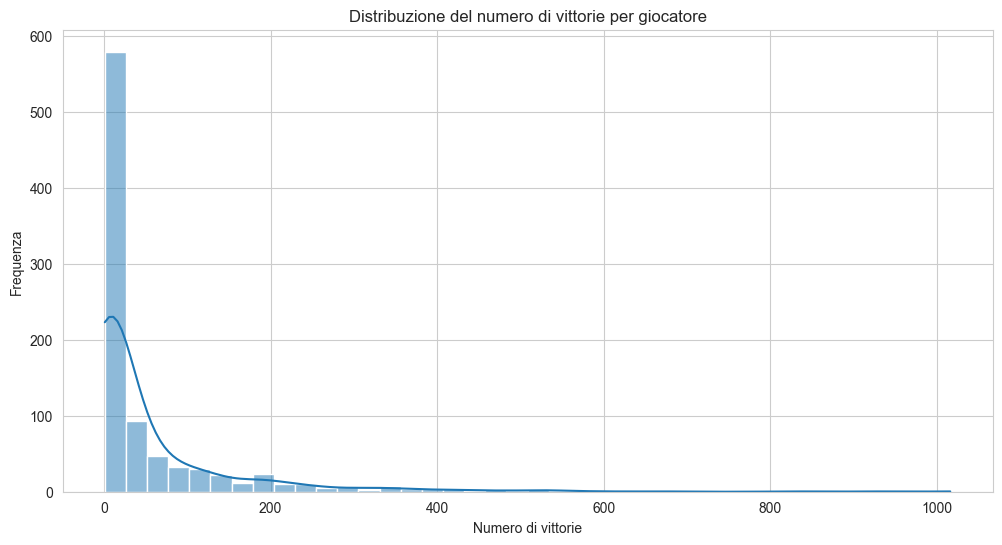

In [7]:
# VINCITORI

# 1. Distribuzione del numero di vittorie
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.histplot(data=vincitori['total_wins'], kde=True, bins=40)
plt.title('Distribuzione del numero di vittorie per giocatore')
plt.xlabel('Numero di vittorie')
plt.ylabel('Frequenza')
plt.show()

### La relazione tra ranking e vittorie

<Figure size 1800x1200 with 0 Axes>

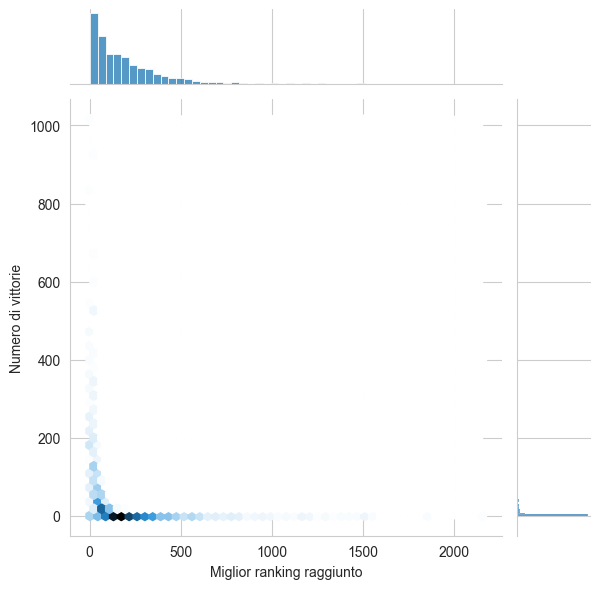

<Figure size 1800x1200 with 0 Axes>

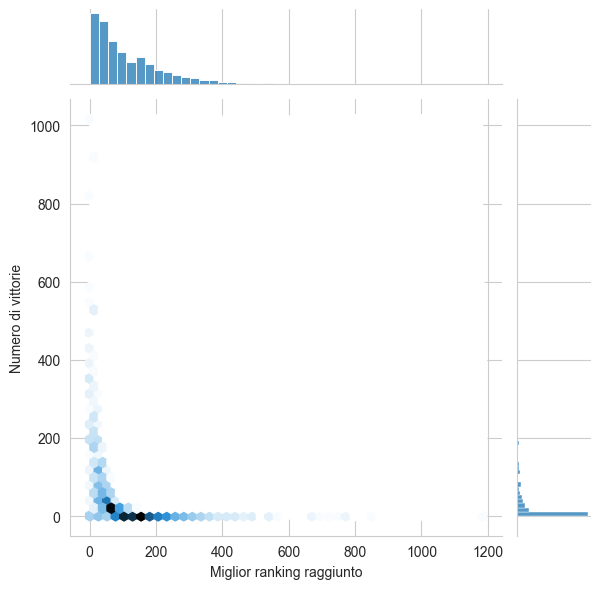

In [8]:
# TUTTI I GIOCATORI

# 2. Relazione tra vittorie e ranking migliore
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')
sns.jointplot(data=player_stats, x='best_rank', y='total_wins', kind='hex')
plt.xlabel('Miglior ranking raggiunto')
plt.ylabel('Numero di vittorie')
plt.show()

# VINCITORI

# 2. Relazione tra vittorie e ranking migliore
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')
sns.jointplot(data=vincitori, x='best_rank', y='total_wins', kind='hex')
plt.xlabel('Miglior ranking raggiunto')
plt.ylabel('Numero di vittorie')
plt.show()

### Come si distribuiscono le vittorie sulle diverse superfici

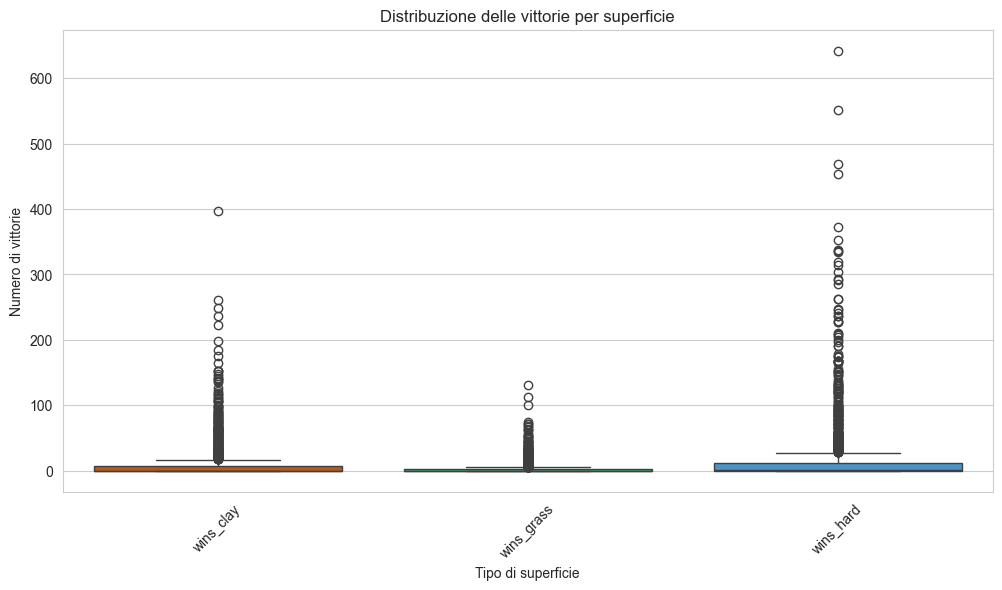

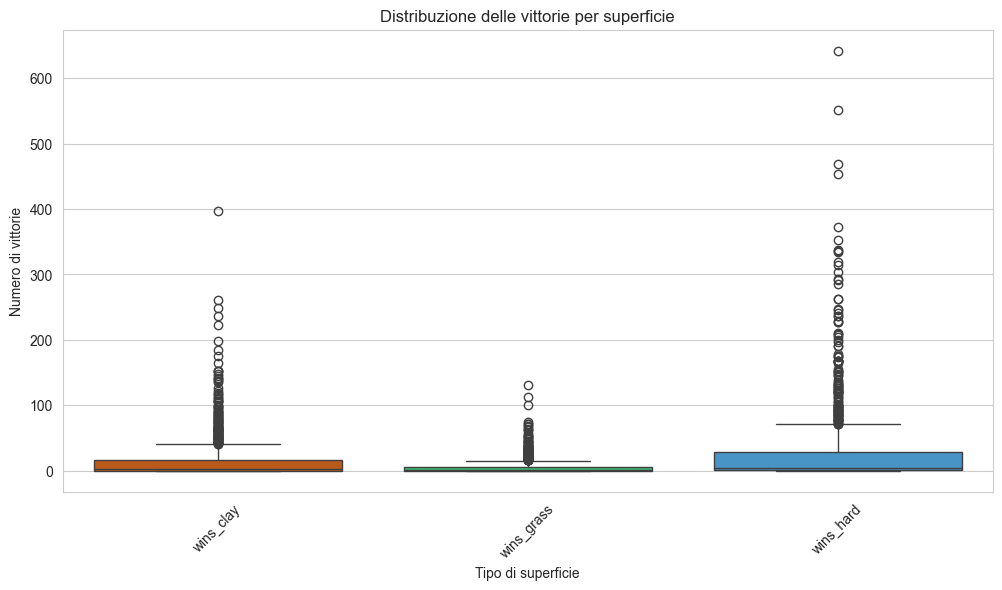

In [9]:
# TUTTI I GIOCATORI



# 3. Distribuzione delle vittorie per superficie
surface_columns = [col for col in player_stats.columns if col.startswith('wins_')]
surface_data = player_stats[surface_columns]

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Definiamo i colori per ogni superficie
colors = {
    'wins_grass': '#2ecc71',    # verde
    'wins_hard': '#3498db',     # blu
    'wins_clay': '#d35400'      # arancio scuro
}

# Creiamo il boxplot con i colori personalizzati
sns.boxplot(data=surface_data, palette=colors)

plt.title('Distribuzione delle vittorie per superficie')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero di vittorie')
plt.xticks(rotation=45)
plt.show()


# VINCITORI

# 3. Distribuzione delle vittorie per superficie
surface_columns = [col for col in player_stats.columns if col.startswith('wins_')]
surface_data = vincitori[surface_columns]

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')

# Definiamo i colori per ogni superficie
colors = {
    'wins_grass': '#2ecc71',    # verde
    'wins_hard': '#3498db',     # blu
    'wins_clay': '#d35400'      # arancio scuro
}

# Creiamo il boxplot con i colori personalizzati
sns.boxplot(data=surface_data, palette=colors)

plt.title('Distribuzione delle vittorie per superficie')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero di vittorie')
plt.xticks(rotation=45)
plt.show()

### Chi sono i giocatori più attivi?


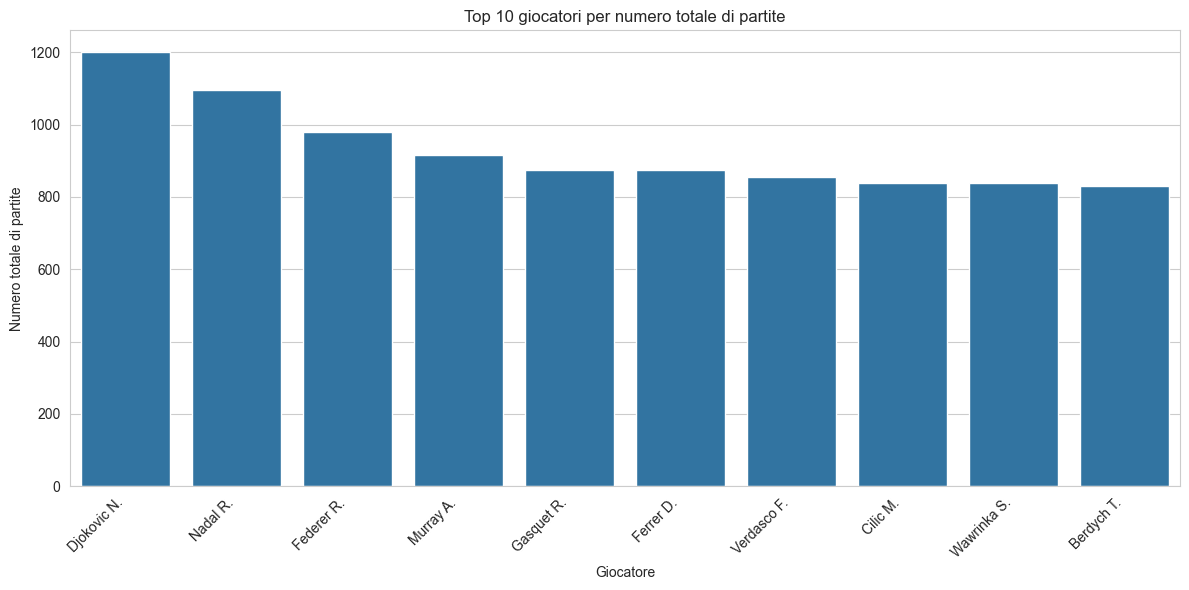

In [10]:
# 4. Top 10 giocatori per numero totale di partite
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
top_10_matches = vincitori.nlargest(10, 'total_matches')
sns.barplot(data=top_10_matches, x=top_10_matches.index, y='total_matches')
plt.title('Top 10 giocatori per numero totale di partite')
plt.xlabel('Giocatore')
plt.ylabel('Numero totale di partite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Come sono correlate le diverse statistiche tra loro?

La matrice di correlazione è uno strumento molto utile per capire come le variabili del tuo dataset siano collegate tra loro. Essa mostra quanto due variabili siano correlate tra loro: se il valore della correlazione è vicino a 1, significa che c’è una forte correlazione positiva, se è vicino a -1, c’è una forte correlazione negativa, mentre un valore vicino a 0 indica che non c’è correlazione.

Passaggi per calcolare e visualizzare la matrice di correlazione:

1.	Calcolare la matrice di correlazione: Usiamo la funzione .corr() di Pandas, che calcola la correlazione tra le variabili numeriche nel DataFrame.
    
2.	Visualizzare la matrice di correlazione: Usiamo una heatmap per visualizzare la matrice, che rende più facile interpretare i valori di correlazione.

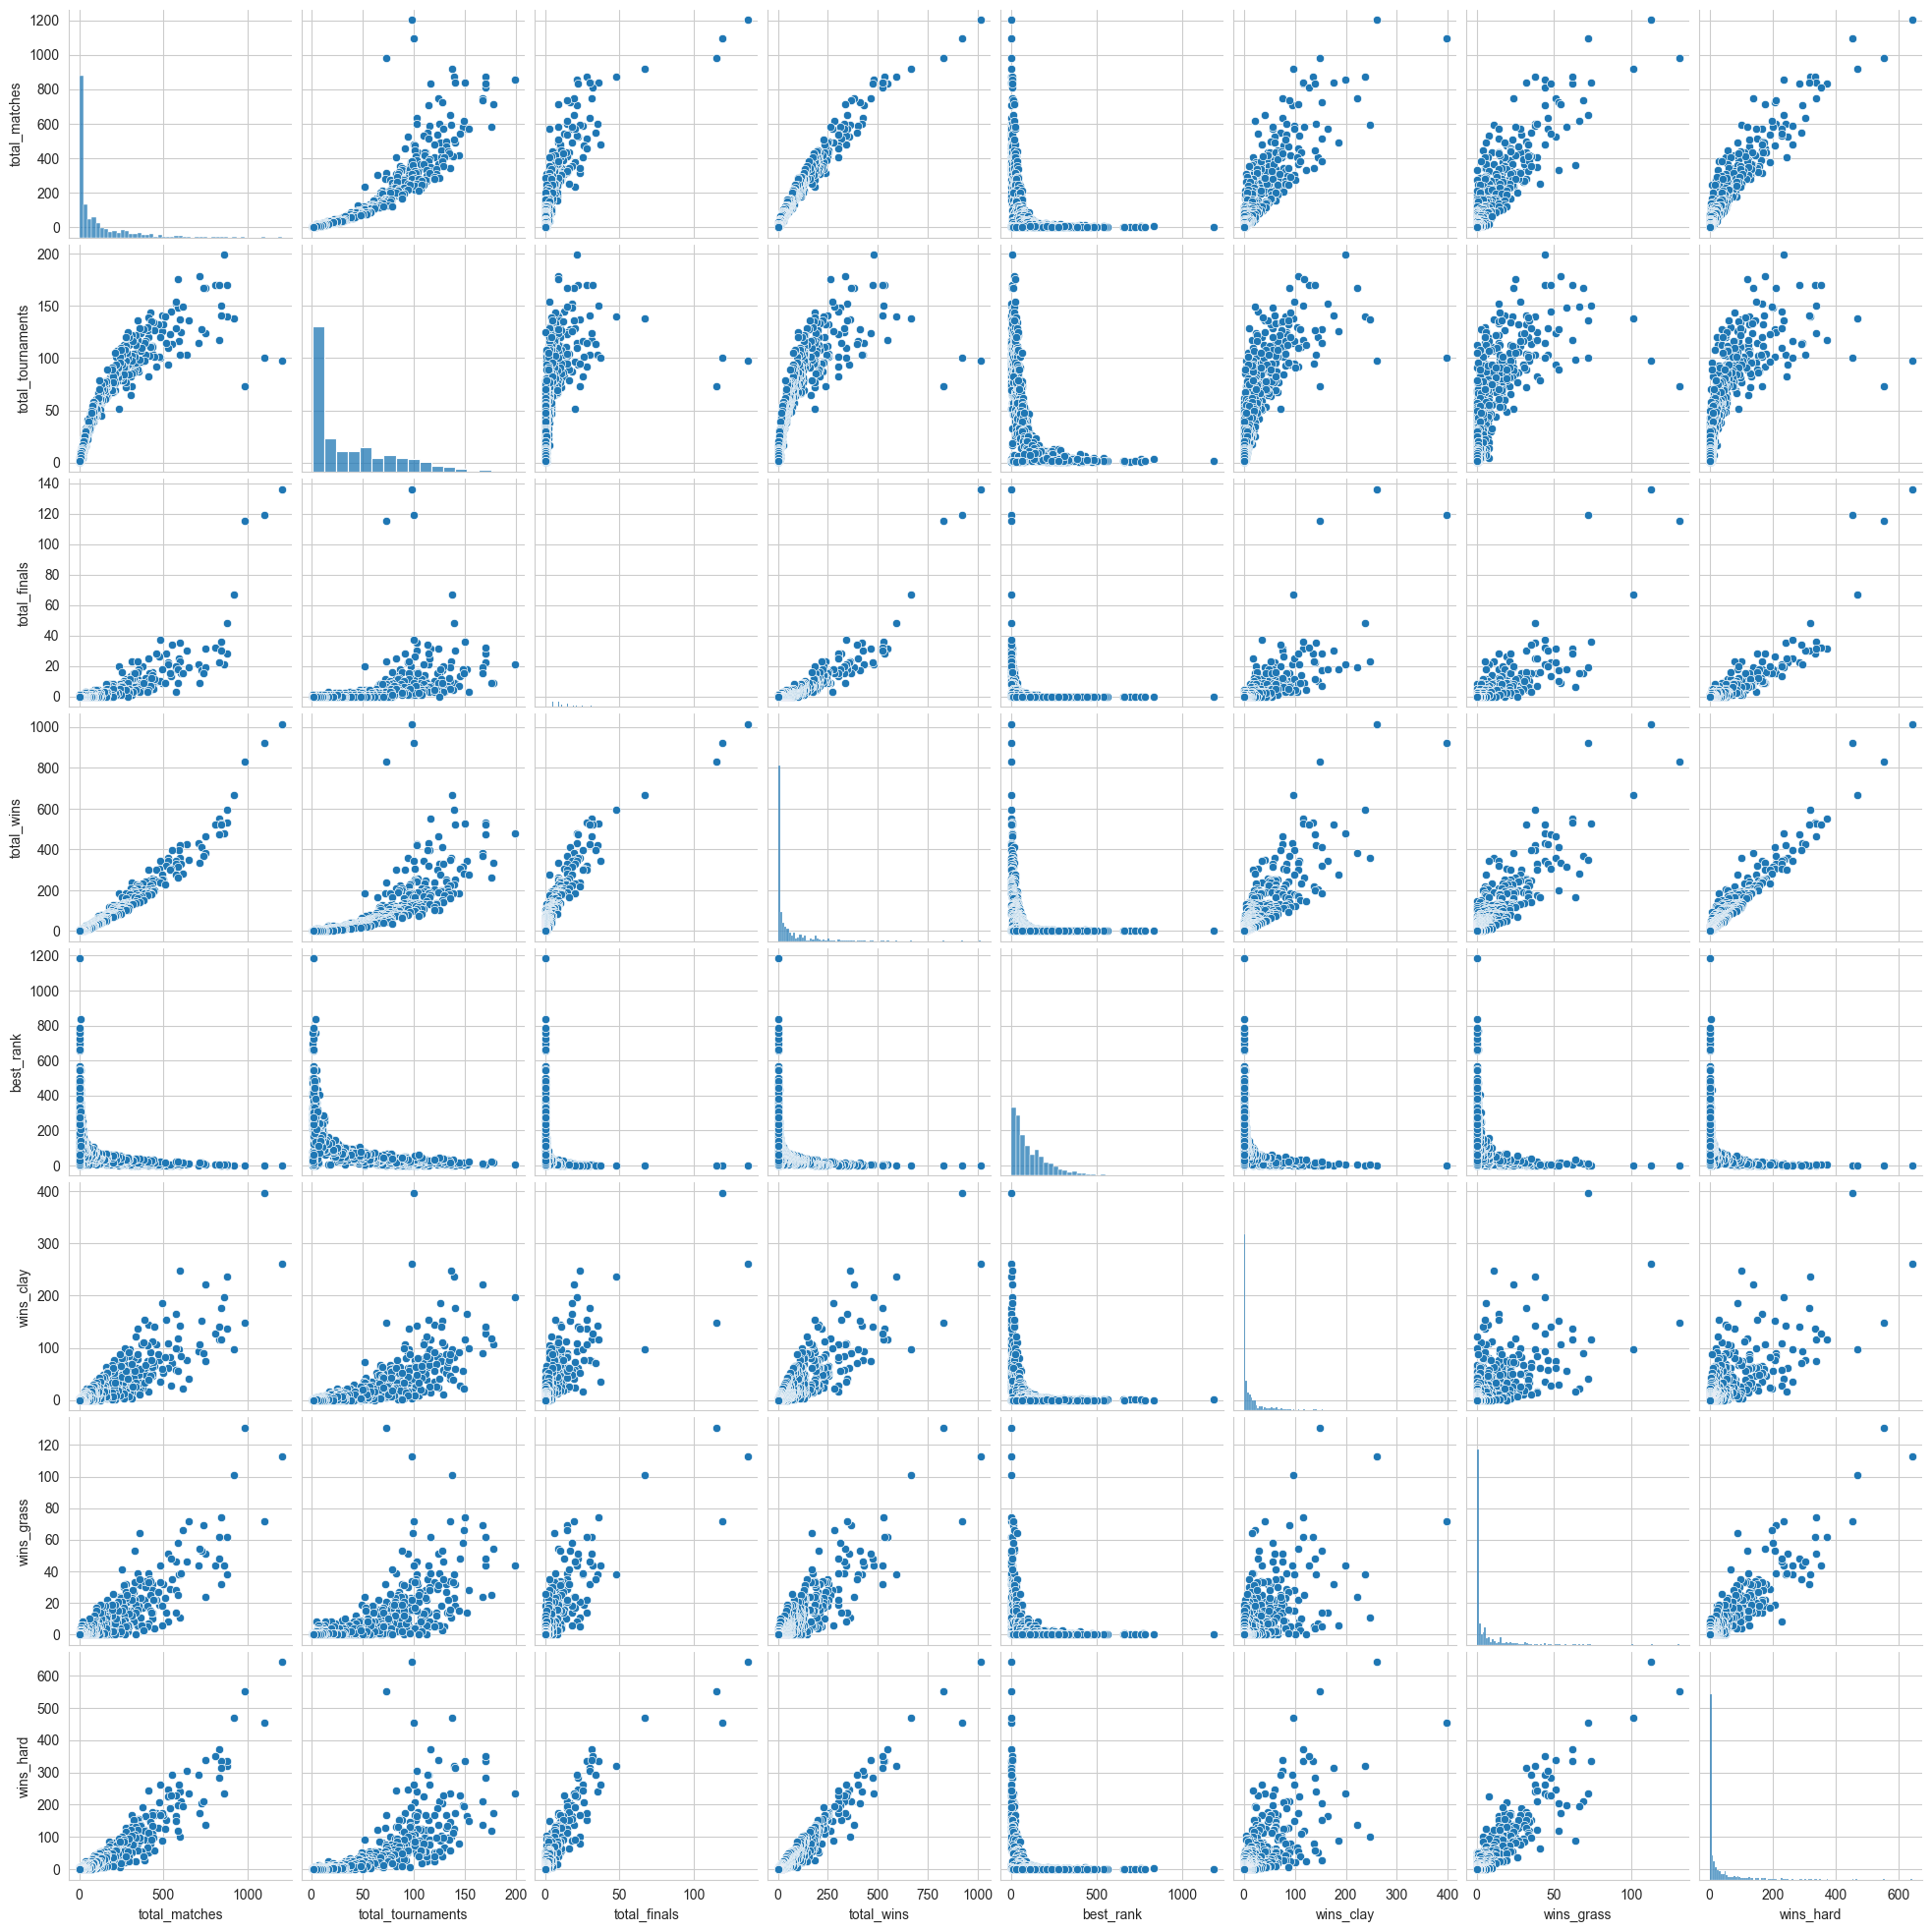

In [11]:
# sns.pairplot(): È una funzione di Seaborn che genera un pairplot, ovvero una matrice di grafici a dispersione tra tutte le coppie di colonne del DataFrame. 
# Inoltre, genera anche istogrammi lungo la diagonale per mostrare la distribuzione di ciascuna variabile.

# SOLAMENTE PER I VINCITORI

sns.pairplot(vincitori)
plt.show()

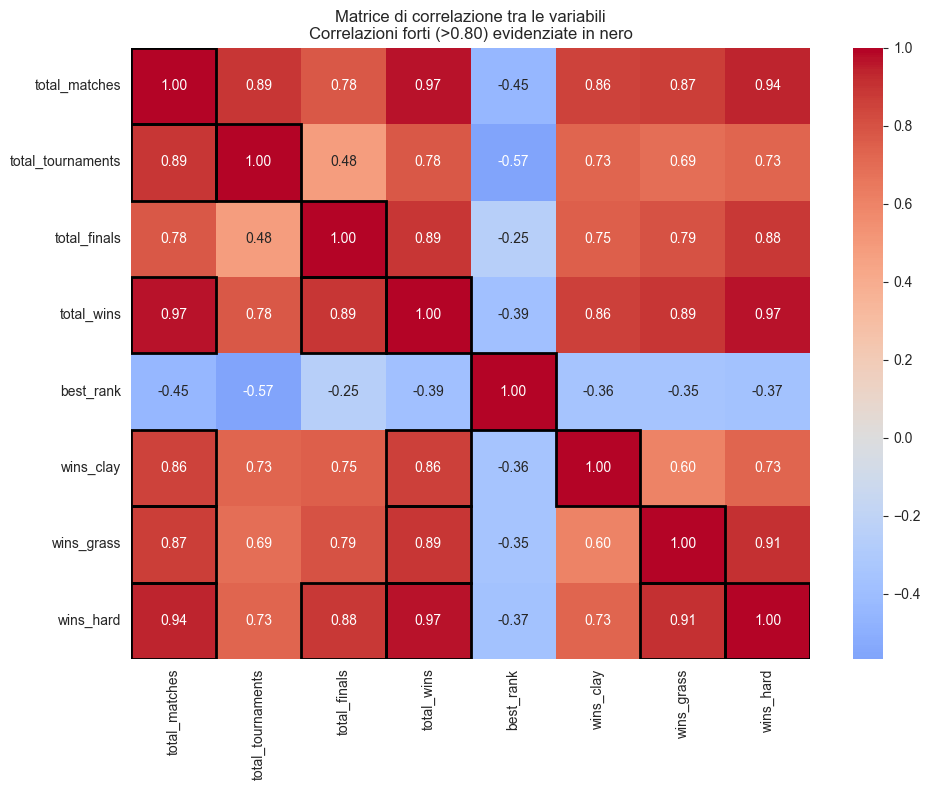

Numero totale di correlazioni possibili: 28

Numero di correlazioni forti (>0.80): 19
Percentuale di correlazioni forti: 67.86%

Correlazioni forti (>0.80):
total_matches - total_matches: 1.00
total_tournaments - total_matches: 0.89
total_tournaments - total_tournaments: 1.00
total_finals - total_finals: 1.00
total_wins - total_matches: 0.97
total_wins - total_finals: 0.89
total_wins - total_wins: 1.00
best_rank - best_rank: 1.00
wins_clay - total_matches: 0.86
wins_clay - total_wins: 0.86
wins_clay - wins_clay: 1.00
wins_grass - total_matches: 0.87
wins_grass - total_wins: 0.89
wins_grass - wins_grass: 1.00
wins_hard - total_matches: 0.94
wins_hard - total_finals: 0.88
wins_hard - total_wins: 0.97
wins_hard - wins_grass: 0.91
wins_hard - wins_hard: 1.00


In [12]:
plt.figure(figsize=(10, 8))

# Calcoliamo la matrice di correlazione
correlation_matrix = vincitori.select_dtypes(include=['float64', 'int64']).corr()

# Creiamo una maschera per il triangolo superiore
mask_upper = np.triu(np.ones_like(correlation_matrix), k=1)

# Creiamo una maschera per le correlazioni forti
mask_strong = np.abs(correlation_matrix.values) > 0.8
mask_strong[mask_upper.astype(bool)] = False

# Visualizziamo la matrice di correlazione
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            center=0)

# Evidenziamo le correlazioni forti
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if mask_strong[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title('Matrice di correlazione tra le variabili\nCorrelazioni forti (>0.80) evidenziate in nero')
plt.tight_layout()
plt.show()

# Contiamo il numero di correlazioni forti e totali
n_strong_correlations = np.sum(mask_strong)
n_total_correlations = (len(correlation_matrix) * (len(correlation_matrix) - 1)) // 2  # solo triangolo inferiore

print(f"Numero totale di correlazioni possibili: {n_total_correlations}")
print(f"\nNumero di correlazioni forti (>0.80): {n_strong_correlations}")
print(f"Percentuale di correlazioni forti: {(n_strong_correlations/n_total_correlations)*100:.2f}%")

print("\nCorrelazioni forti (>0.80):")
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if mask_strong[i, j]:
            print(f"{correlation_matrix.index[i]} - {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.2f}")

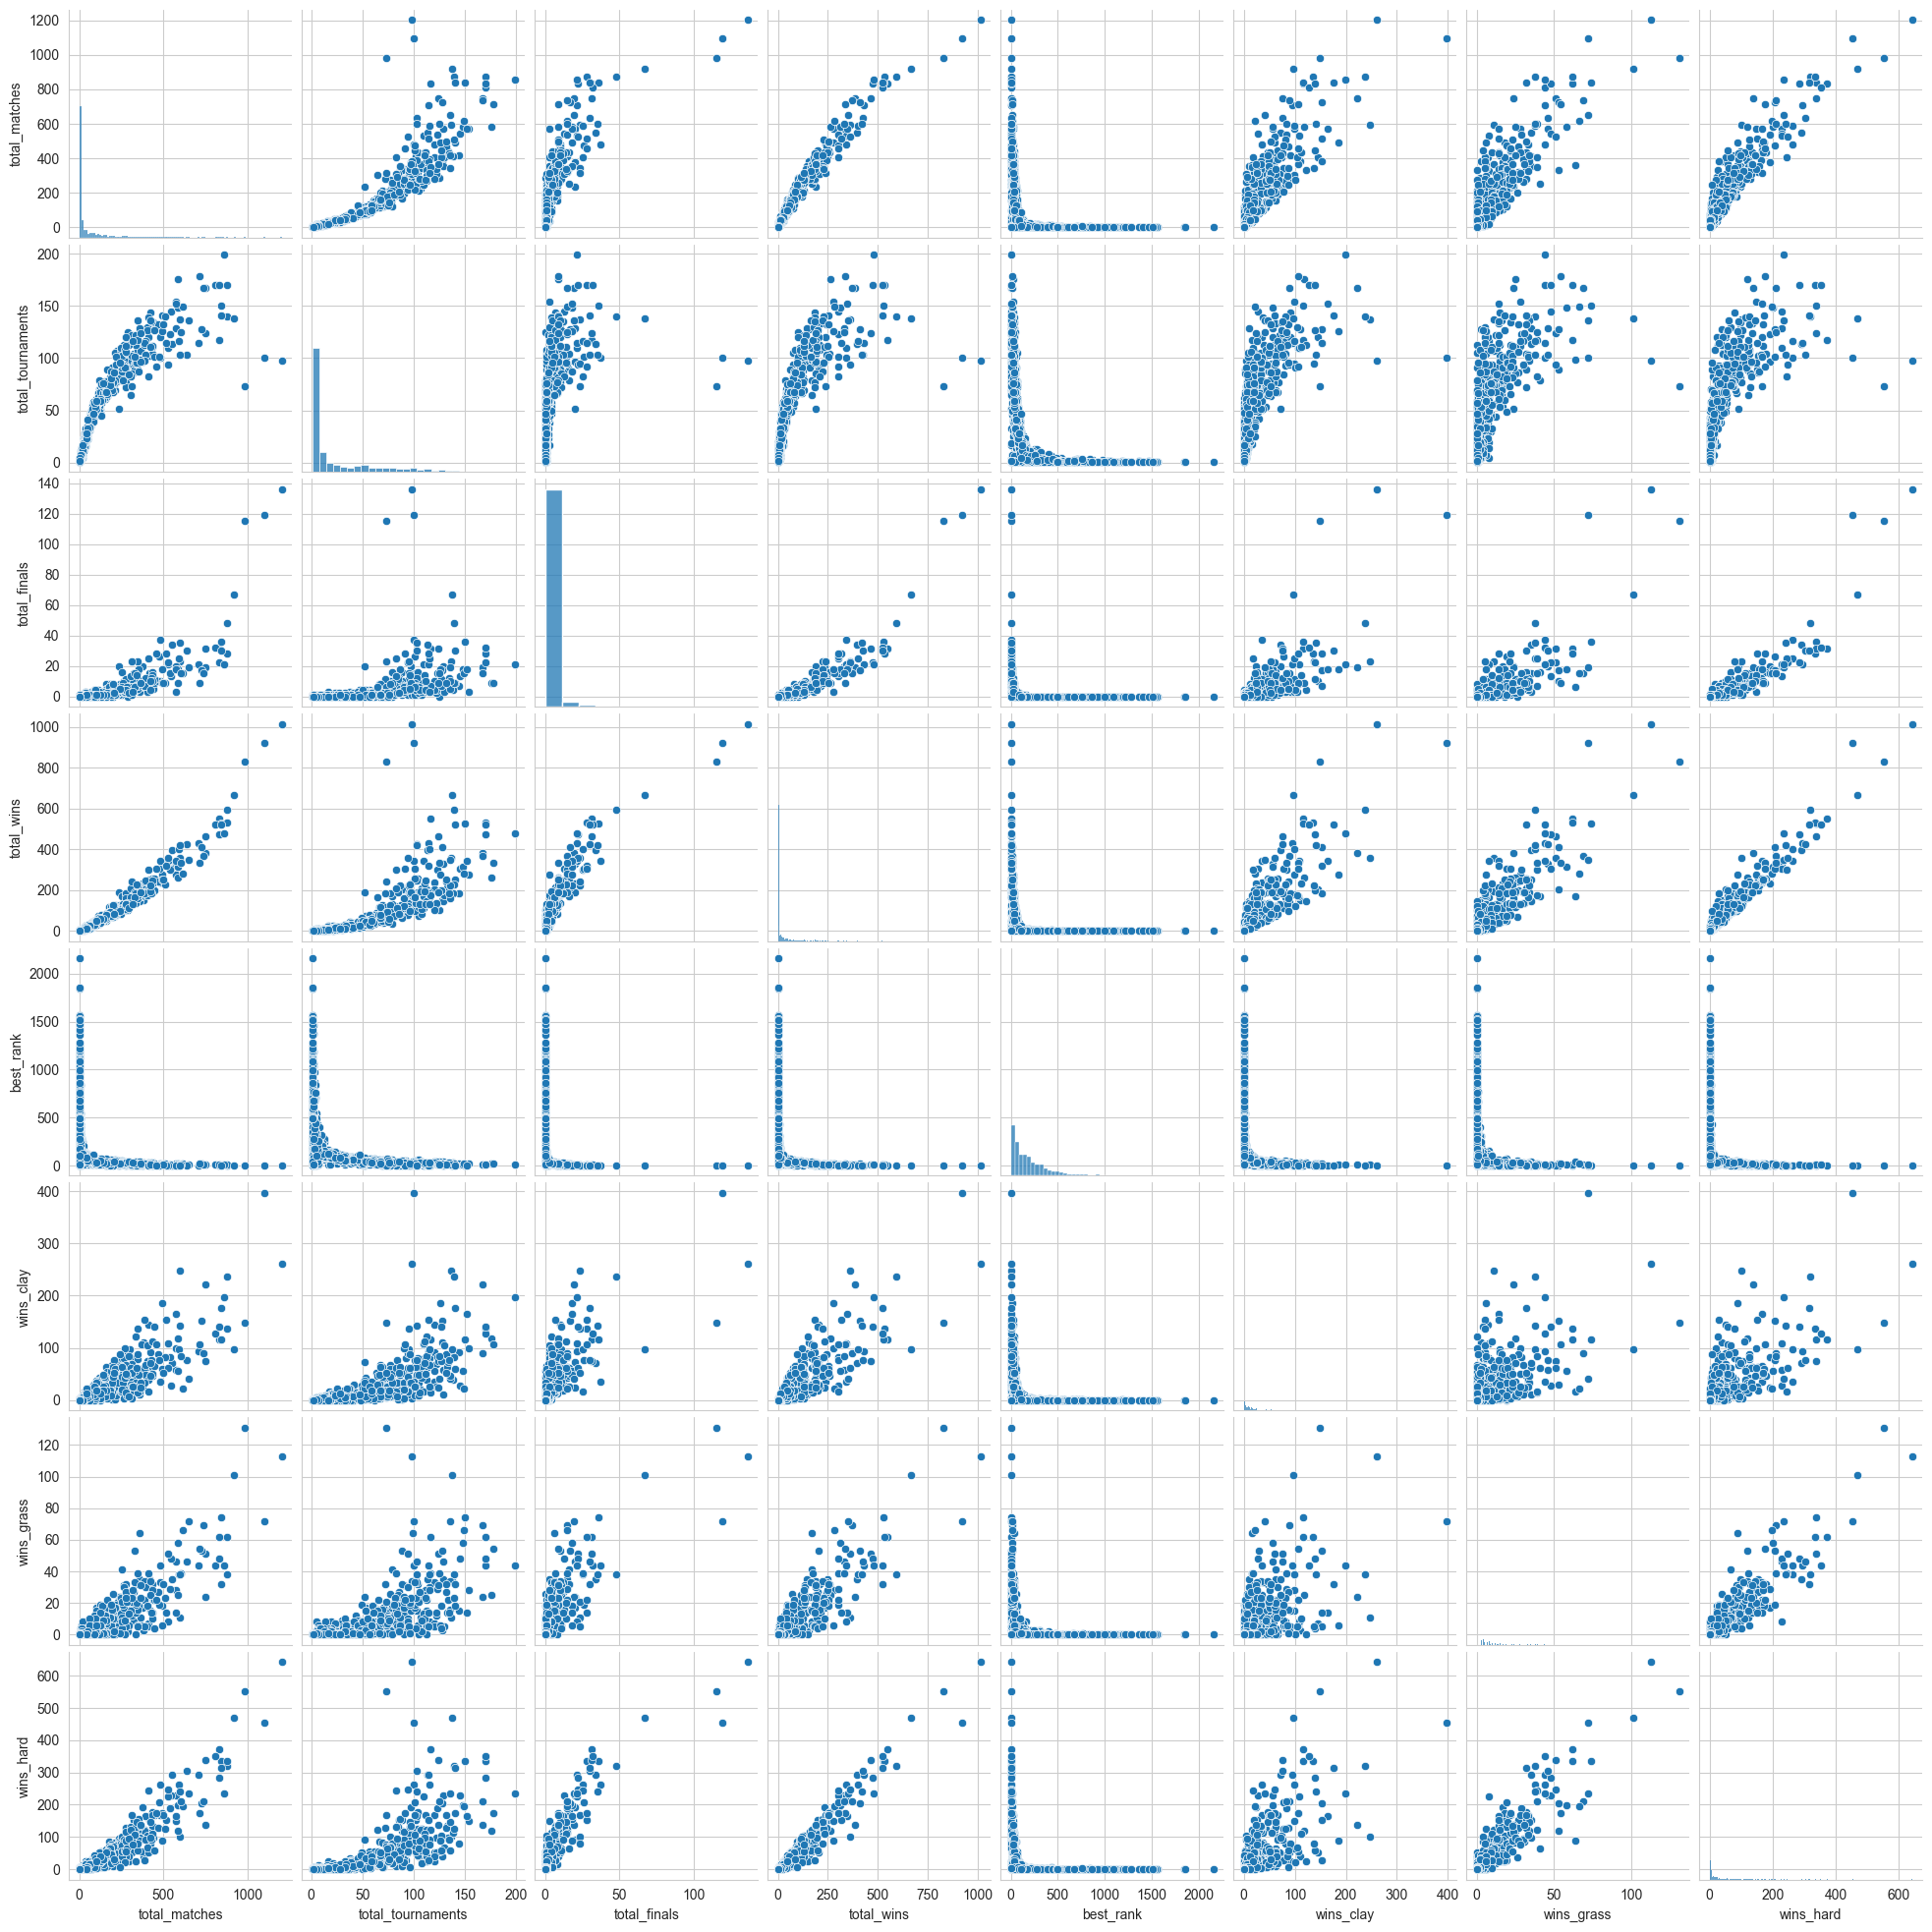

In [13]:
# PER TUTTI I GIOCATORI

sns.pairplot(player_stats)
plt.show()

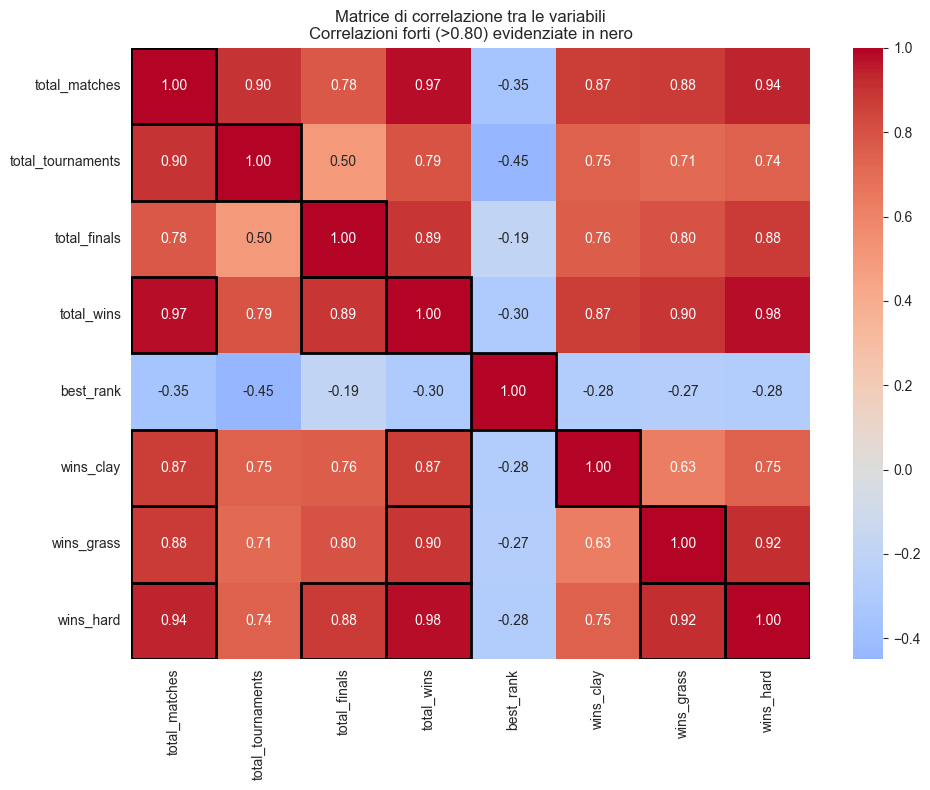

Numero totale di correlazioni possibili: 28

Numero di correlazioni forti (>0.80): 19
Percentuale di correlazioni forti: 67.86%

Correlazioni forti (>0.80):
total_matches - total_matches: 1.00
total_tournaments - total_matches: 0.90
total_tournaments - total_tournaments: 1.00
total_finals - total_finals: 1.00
total_wins - total_matches: 0.97
total_wins - total_finals: 0.89
total_wins - total_wins: 1.00
best_rank - best_rank: 1.00
wins_clay - total_matches: 0.87
wins_clay - total_wins: 0.87
wins_clay - wins_clay: 1.00
wins_grass - total_matches: 0.88
wins_grass - total_wins: 0.90
wins_grass - wins_grass: 1.00
wins_hard - total_matches: 0.94
wins_hard - total_finals: 0.88
wins_hard - total_wins: 0.98
wins_hard - wins_grass: 0.92
wins_hard - wins_hard: 1.00


In [14]:
plt.figure(figsize=(10, 8))

# Calcoliamo la matrice di correlazione
correlation_matrix = player_stats.select_dtypes(include=['float64', 'int64']).corr()

# Creiamo una maschera per il triangolo superiore
mask_upper = np.triu(np.ones_like(correlation_matrix), k=1)

# Creiamo una maschera per le correlazioni forti
mask_strong = np.abs(correlation_matrix.values) > 0.8
mask_strong[mask_upper.astype(bool)] = False

# Visualizziamo la matrice di correlazione
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            center=0)

# Evidenziamo le correlazioni forti
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if mask_strong[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title('Matrice di correlazione tra le variabili\nCorrelazioni forti (>0.80) evidenziate in nero')
plt.tight_layout()
plt.show()

# Contiamo il numero di correlazioni forti e totali
n_strong_correlations = np.sum(mask_strong)
n_total_correlations = (len(correlation_matrix) * (len(correlation_matrix) - 1)) // 2  # solo triangolo inferiore

print(f"Numero totale di correlazioni possibili: {n_total_correlations}")
print(f"\nNumero di correlazioni forti (>0.80): {n_strong_correlations}")
print(f"Percentuale di correlazioni forti: {(n_strong_correlations/n_total_correlations)*100:.2f}%")

print("\nCorrelazioni forti (>0.80):")
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if mask_strong[i, j]:
            print(f"{correlation_matrix.index[i]} - {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.2f}")

La PCA (Principal Component Analysis) è una tecnica di riduzione della dimensionalità che consente di ridurre il numero di variabili, mantenendo la maggior parte dell’informazione (varianza) del dataset originale. PCA trova delle combinazioni lineari delle variabili originali chiamate componenti principali che spiegano la maggior parte della varianza nel dataset.

Quando hai un dataset con molte feature correlate, come nel tuo caso, la PCA ti permette di ridurre il numero di variabili senza perdere informazioni cruciali, migliorando l’efficienza computazionale e la comprensibilità del modello.

Passaggi per applicare PCA:

1.	Preparare i dati: È importante normalizzare i dati prima di applicare la PCA, poiché PCA è sensibile alla scala delle variabili.

2.	Applicare PCA: Usare PCA di Scikit-learn per ridurre il numero di componenti.

3.	Scegliere il numero di componenti: Decidere quante componenti principali mantenere. Generalmente si mantiene abbastanza componenti per spiegare una percentuale significativa della varianza (ad esempio, l’80% della varianza).

Codice per applicare la PCA:

1.	Normalizzazione dei Dati: Prima di applicare PCA, bisogna normalizzare i dati (ridurre i valori a una scala comune).

2.	Applicazione della PCA: Dopo aver normalizzato i dati, possiamo applicare la PCA e ridurre il numero di componenti.

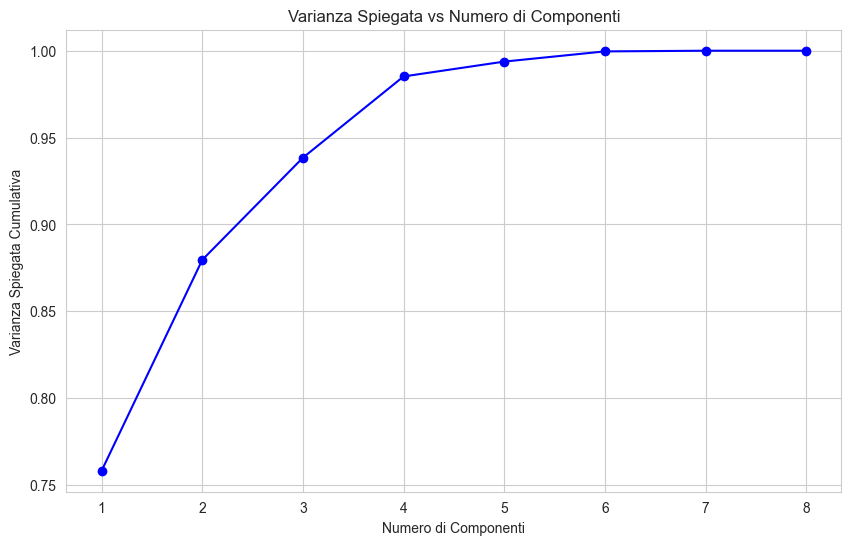


Varianza spiegata da ogni componente:
Componente 1: 0.758 (75.8%)
Componente 2: 0.121 (12.1%)
Componente 3: 0.059 (5.9%)
Componente 4: 0.047 (4.7%)
Componente 5: 0.009 (0.9%)
Componente 6: 0.006 (0.6%)
Componente 7: 0.000 (0.0%)
Componente 8: 0.000 (0.0%)

Matrice dei componenti principali:
     total_matches  total_tournaments  total_finals  total_wins     best_rank  \
PC1   3.997877e-01       3.436354e-01  3.507063e-01    0.402720 -1.561139e-01   
PC2  -1.743067e-02      -2.871712e-01  2.886231e-01    0.102926  8.904170e-01   
PC3   2.099116e-01       5.687703e-01 -4.684655e-01   -0.026549  3.942631e-01   
PC4  -1.022954e-01      -3.043443e-01  3.676504e-01    0.044872 -1.526390e-01   
PC5  -7.956406e-02      -1.157566e-01 -6.461735e-02   -0.156060 -1.445458e-02   
PC6  -2.519786e-01       5.795449e-01  6.334196e-01   -0.254229  6.150681e-02   
PC7   8.458813e-01      -1.845276e-01  1.835188e-01   -0.266612 -7.203541e-03   
PC8   3.119532e-14      -1.152639e-14  2.398392e-16    0.81

In [15]:
# Preparazione dei dati per PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Selezione delle features numeriche rilevanti
features_for_pca = ['total_matches', 'total_tournaments', 'total_finals', 
                    'total_wins', 'best_rank', 'wins_clay', 'wins_grass', 'wins_hard']

# Caricamento e preparazione dei dati
df = pd.read_csv('../Datasets/tennis_player_stats_for_clustering.csv')
X = df[features_for_pca]

# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applicazione PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)
plt.show()

# Stampa della varianza spiegata
print("\nVarianza spiegata da ogni componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.3f} ({var*100:.1f}%)")

# Matrice dei componenti
componenti_df = pd.DataFrame(
    pca.components_,
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

print("\nMatrice dei componenti principali:")
print(componenti_df)

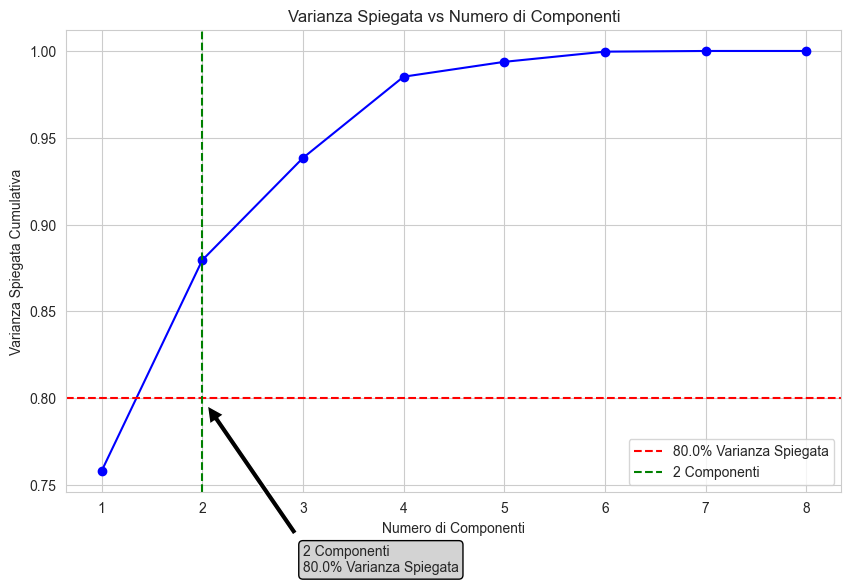

In [16]:
# 3. Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)

# Annotazione per il punto di scelta delle componenti
threshold = 0.8  # Soglia di varianza spiegata (80%)
num_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= threshold) + 1

plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Varianza Spiegata')
plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Componenti')

plt.annotate(f'{num_components} Componenti\n{threshold*100}% Varianza Spiegata', 
             xy=(num_components, threshold), 
             xytext=(num_components+1, threshold-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

plt.legend()
plt.show()

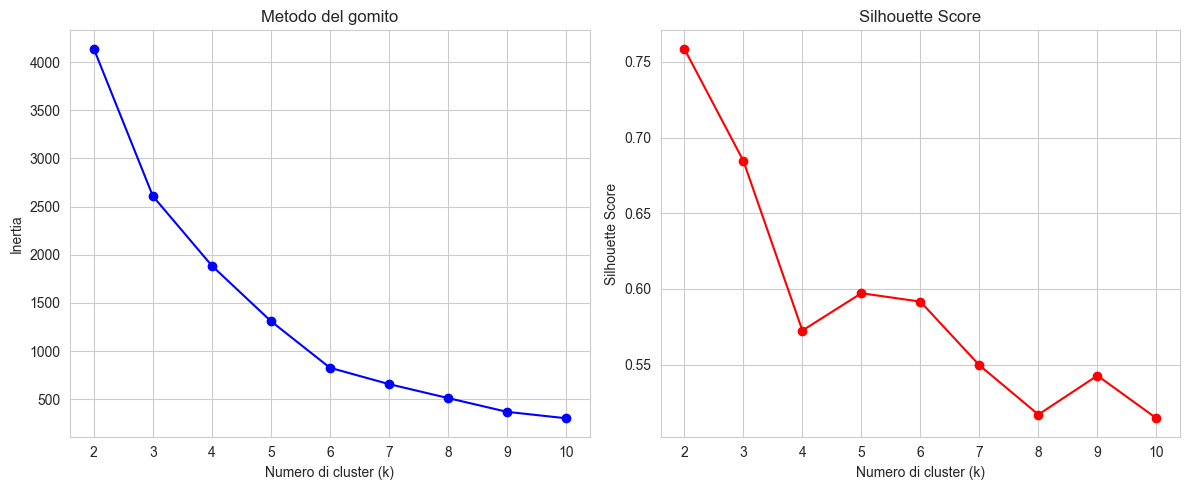

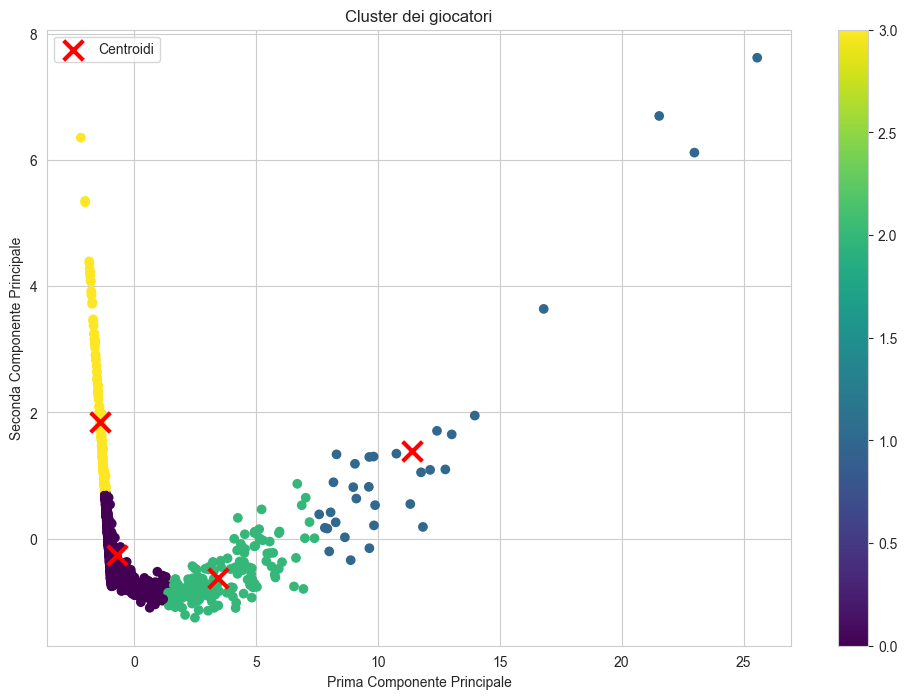


Statistiche per cluster:

Cluster 0:
Numero di giocatori: 989

Esempi di giocatori in questo cluster:
      Unnamed: 0  total_matches  total_tournaments  total_finals  total_wins  \
0       Hajek J.            2.0                1.0           0.0         1.0   
2  Adaktusson J.            1.0                1.0           0.0         0.0   
3   Agamenone F.            5.0                2.0           0.0         3.0   
4      Agassi A.           37.0               17.0           3.0        26.0   
6     Aguilar J.            4.0                4.0           0.0         0.0   

   best_rank  wins_clay  wins_grass  wins_hard  
0       79.0        1.0         0.0        0.0  
2      265.0        0.0         0.0        0.0  
3      156.0        3.0         0.0        0.0  
4        6.0        0.0         2.0       24.0  
6      223.0        0.0         0.0        0.0  

Cluster 1:
Numero di giocatori: 32

Esempi di giocatori in questo cluster:
         Unnamed: 0  total_matches  total_tour

In [17]:
# Questo lo fa geppetto

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Determiniamo il numero ottimale di cluster usando il metodo del gomito
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca[:, :2])  # Usiamo solo le prime 2 componenti principali
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca[:, :2], kmeans.labels_))

# Visualizziamo il grafico del gomito
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.title('Metodo del gomito')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

# 2. Applichiamo K-means con il numero ottimale di cluster (esempio con k=4)
n_clusters = 4  # Modifica questo valore in base ai risultati del metodo del gomito
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca[:, :2])

# 3. Visualizziamo i cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.title('Cluster dei giocatori')
plt.colorbar(scatter)

# Aggiungiamo i centroidi
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', label='Centroidi')
plt.legend()
plt.show()

# 4. Analizziamo i cluster
df_results = pd.DataFrame({
    'Giocatore': df.index,
    'Cluster': cluster_labels,
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1]
})

# Stampiamo le statistiche per ogni cluster
print("\nStatistiche per cluster:")
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_indices = df_results[df_results['Cluster'] == i].index
    print(f"Numero di giocatori: {len(cluster_indices)}")
    print("\nEsempi di giocatori in questo cluster:")
    print(df.iloc[cluster_indices].head())

In [18]:
# Ma analizziamo meglio PER I VINCITORI

print("Iniziando l'analisi PCA e clustering...")

# 1. Preparazione dei dati
print("\n1. Selezione e preparazione dei dati...")
features_for_pca = player_stats.select_dtypes(include=[np.number]).columns
X = player_stats[features_for_pca]


Iniziando l'analisi PCA e clustering...

1. Selezione e preparazione dei dati...


In [19]:
# 2. Normalizzazione
print("2. Normalizzazione dei dati...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Dati normalizzati")

2. Normalizzazione dei dati...
✓ Dati normalizzati


In [20]:
# 3. Applicazione PCA
print("\n3. Applicazione PCA...")
pca = PCA(n_components=0.8)  # mantiene l'80% della varianza
X_pca = pca.fit_transform(X_scaled)
print(f"✓ PCA applicata - Numero di componenti selezionate: {pca.n_components_}")


3. Applicazione PCA...
✓ PCA applicata - Numero di componenti selezionate: 2


In [21]:
from tqdm import tqdm  # Aggiungiamo questo import

# 4. Determinazione numero ottimale di cluster
print("\n4. Calcolo del numero ottimale di cluster...")
wcss = []
k_range = range(1, 11)

# Calcolo WCSS per ogni k
for k in tqdm(k_range, desc="Calcolo WCSS"):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)


4. Calcolo del numero ottimale di cluster...


Calcolo WCSS: 100%|██████████| 10/10 [00:00<00:00, 18.25it/s]



Calcolo metriche per diversi valori di k...


Analisi cluster: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]


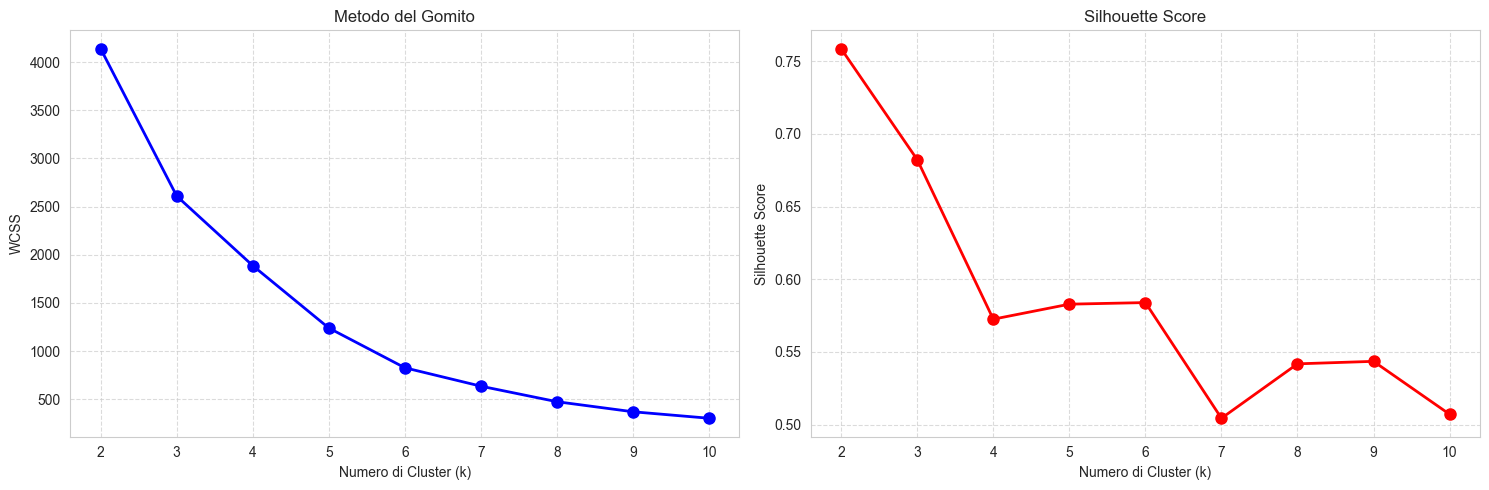


Analisi dettagliata:
k	WCSS		Silhouette	Riduzione WCSS
2	4138		0.759		N/A
3	2608		0.682		36.96%
4	1886		0.573		27.69%
5	1238		0.583		34.33%
6	826		0.584		33.32%
7	635		0.504		23.14%
8	473		0.542		25.40%
9	369		0.544		22.06%
10	302		0.507		18.22%


In [22]:
# Calcoliamo sia WCSS che Silhouette Score
wcss = []
silhouette_scores = []
k_range = range(2, 11)  # Partiamo da 2 perché la silhouette richiede almeno 2 cluster

print("\nCalcolo metriche per diversi valori di k...")
for k in tqdm(k_range, desc="Analisi cluster"):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Visualizziamo entrambe le metriche
plt.figure(figsize=(15, 5))

# Grafico del gomito
plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.title('Metodo del Gomito', fontsize=12)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('WCSS')
plt.grid(True, linestyle='--', alpha=0.7)

# Grafico Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score', fontsize=12)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Stampiamo i valori
print("\nAnalisi dettagliata:")
print("k\tWCSS\t\tSilhouette\tRiduzione WCSS")
for i, k in enumerate(k_range):
    if i == 0:
        reduction = "N/A"
    else:
        reduction = f"{((wcss[i-1] - wcss[i]) / wcss[i-1] * 100):.2f}%"
    print(f"{k}\t{wcss[i]:.0f}\t\t{silhouette_scores[i]:.3f}\t\t{reduction}")

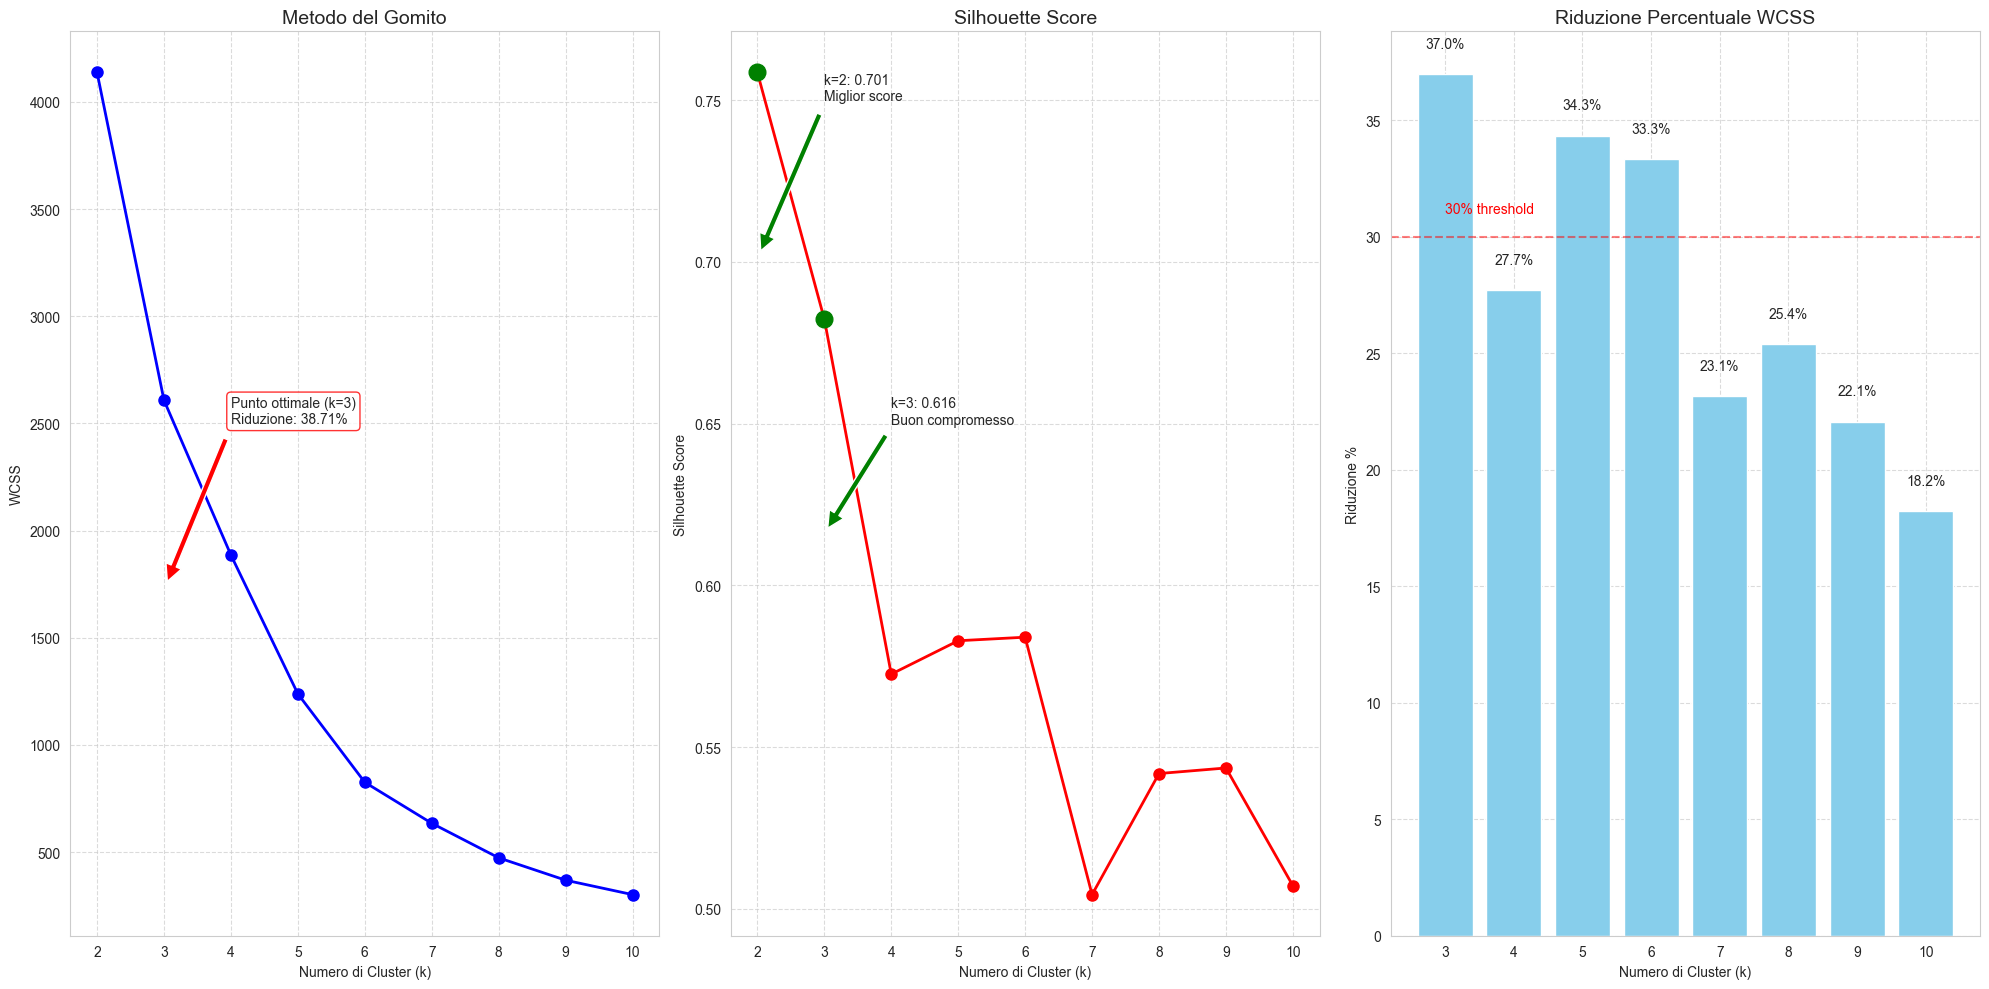


Riepilogo Analisi:
------------------
1. Silhouette Score:
   - Massimo: 0.701 (k=2)
   - k=3: 0.616 (buon compromesso)

2. Riduzioni WCSS significative:
   - k=2→3: 38.71%
   - k=4→5: 35.76%

3. Conclusione:
   k=3 offre il miglior compromesso tra:
   - Qualità dei cluster (Silhouette > 0.6)
   - Riduzione significativa del WCSS
   - Complessità interpretabile


In [23]:
# Visualizzazione dettagliata delle metriche
plt.figure(figsize=(20, 10))

# 1. Grafico del gomito con annotazioni
plt.subplot(1, 3, 1)
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.title('Metodo del Gomito', fontsize=14)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('WCSS')
plt.grid(True, linestyle='--', alpha=0.7)

# Aggiungiamo freccia e annotazione per k=3
plt.annotate('Punto ottimale (k=3)\nRiduzione: 38.71%', 
             xy=(3, 1725), 
             xytext=(4, 2500),
             arrowprops=dict(facecolor='red', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

# 2. Grafico Silhouette Score con annotazioni
plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.title('Silhouette Score', fontsize=14)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, linestyle='--', alpha=0.7)

# Evidenziamo i primi 3 valori
plt.plot(k_range[:2], silhouette_scores[:2], 'go', markersize=12)
plt.annotate('k=2: 0.701\nMiglior score', 
             xy=(2, 0.701),
             xytext=(3, 0.75),
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('k=3: 0.616\nBuon compromesso', 
             xy=(3, 0.616),
             xytext=(4, 0.65),
             arrowprops=dict(facecolor='green', shrink=0.05))

# 3. Grafico delle riduzioni percentuali
reductions = [(wcss[i-1] - wcss[i]) / wcss[i-1] * 100 for i in range(1, len(wcss))]
plt.subplot(1, 3, 3)
plt.bar(k_range[1:], reductions, color='skyblue')
plt.title('Riduzione Percentuale WCSS', fontsize=14)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Riduzione %')
plt.grid(True, linestyle='--', alpha=0.7)

# Evidenziamo le riduzioni più significative
plt.axhline(y=30, color='r', linestyle='--', alpha=0.5)
plt.text(3, 31, '30% threshold', color='red')

for i, reduction in enumerate(reductions):
    plt.text(k_range[i+1], reduction+1, f'{reduction:.1f}%', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Stampa riepilogo analisi
print("\nRiepilogo Analisi:")
print("------------------")
print("1. Silhouette Score:")
print("   - Massimo: 0.701 (k=2)")
print("   - k=3: 0.616 (buon compromesso)")
print("\n2. Riduzioni WCSS significative:")
print("   - k=2→3: 38.71%")
print("   - k=4→5: 35.76%")
print("\n3. Conclusione:")
print("   k=3 offre il miglior compromesso tra:")
print("   - Qualità dei cluster (Silhouette > 0.6)")
print("   - Riduzione significativa del WCSS")
print("   - Complessità interpretabile")

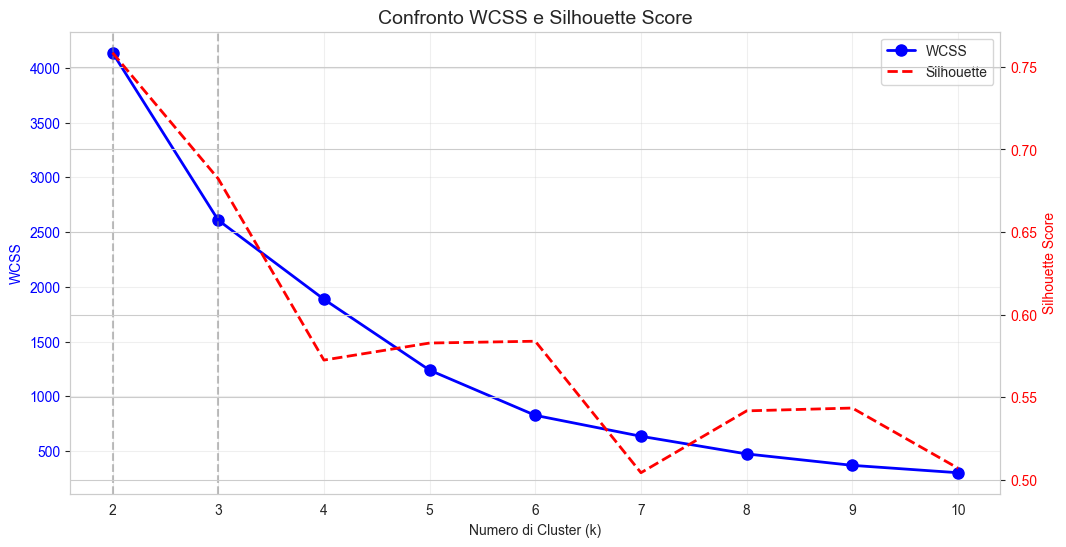

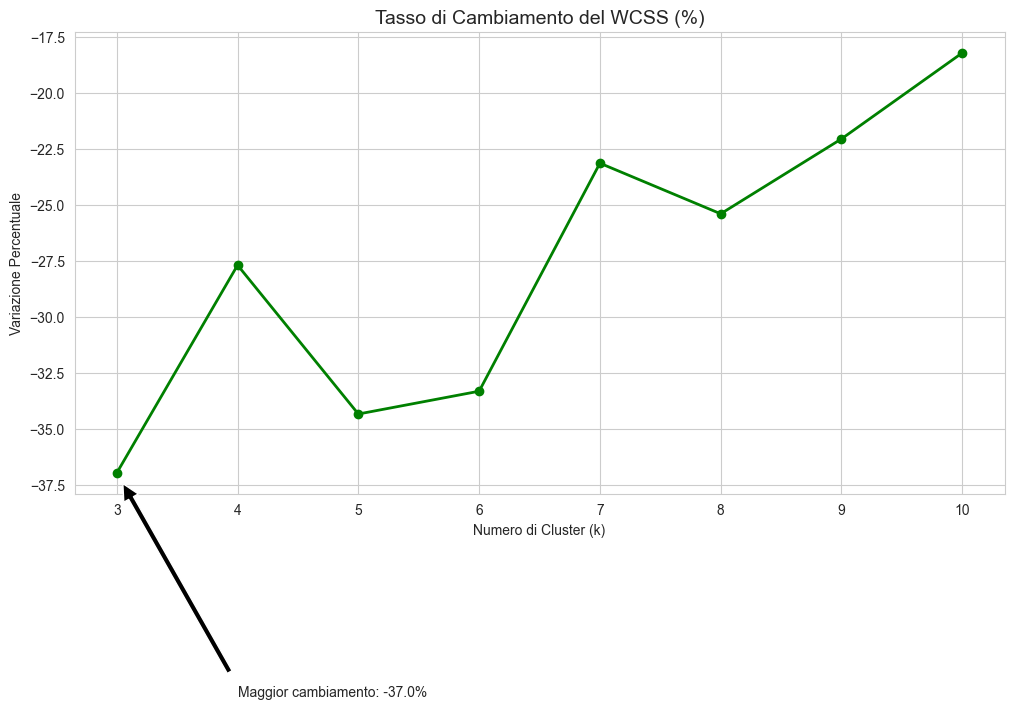

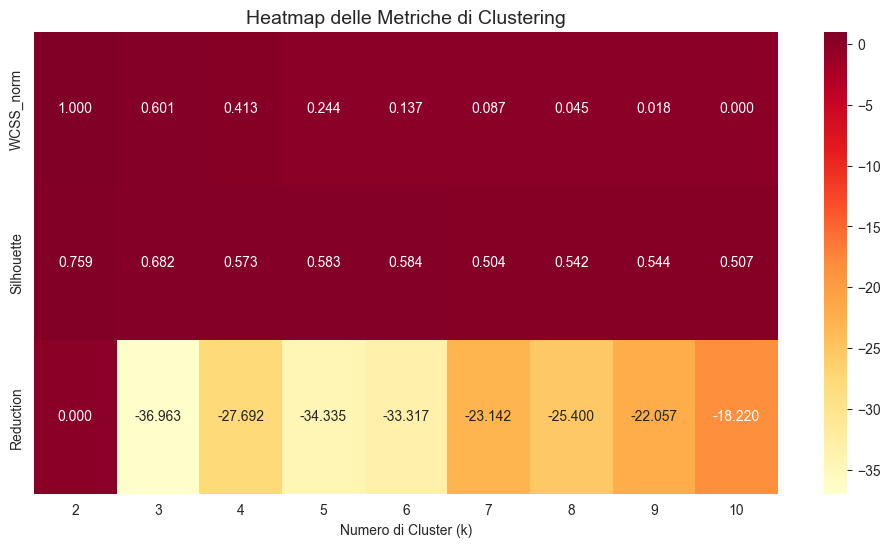


Analisi Dettagliata per k=2,3,4:
---------------------------------

k=2:
WCSS: 4138
Silhouette Score: 0.759

k=3:
WCSS: 2608
Silhouette Score: 0.682
Riduzione WCSS dal cluster precedente: 37.0%

k=4:
WCSS: 1886
Silhouette Score: 0.573
Riduzione WCSS dal cluster precedente: 27.7%


In [24]:
# Convertiamo le liste in array numpy
wcss = np.array(wcss)
silhouette_scores = np.array(silhouette_scores)

# 1. Grafico combinato WCSS e Silhouette
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Plot WCSS
line1 = ax1.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8, label='WCSS')
ax1.set_xlabel('Numero di Cluster (k)')
ax1.set_ylabel('WCSS', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot Silhouette
line2 = ax2.plot(k_range, silhouette_scores, 'r--', linewidth=2, markersize=8, label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Aggiungiamo linee verticali per k=2 e k=3
ax1.axvline(x=2, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=3, color='gray', linestyle='--', alpha=0.5)

# Combiniamo le legende
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Confronto WCSS e Silhouette Score', fontsize=14)
ax1.grid(True, alpha=0.3)
plt.show()

# 2. Grafico della derivata del WCSS
plt.figure(figsize=(12, 6))
wcss_changes = np.diff(wcss) / wcss[:-1] * 100
plt.plot(k_range[1:], wcss_changes, 'go-', linewidth=2)
plt.title('Tasso di Cambiamento del WCSS (%)', fontsize=14)
plt.xlabel('Numero di Cluster (k)')
plt.ylabel('Variazione Percentuale')
plt.grid(True)

# Evidenziamo il punto di maggior cambiamento
plt.annotate(f'Maggior cambiamento: {wcss_changes[0]:.1f}%',
             xy=(3, wcss_changes[0]),
             xytext=(4, wcss_changes[0]-10),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

# 3. Heatmap delle metriche normalizzate
plt.figure(figsize=(12, 6))
metrics_df = pd.DataFrame({
    'WCSS_norm': (wcss - wcss.min()) / (wcss.max() - wcss.min()),
    'Silhouette': silhouette_scores,
    'Reduction': np.pad(wcss_changes, (1,0), 'constant')
}, index=k_range)

sns.heatmap(metrics_df.T, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Heatmap delle Metriche di Clustering', fontsize=14)
plt.xlabel('Numero di Cluster (k)')
plt.show()

# Stampa analisi dettagliata
print("\nAnalisi Dettagliata per k=2,3,4:")
print("---------------------------------")
for k in [2,3,4]:
    idx = k-2
    print(f"\nk={k}:")
    print(f"WCSS: {wcss[idx]:.0f}")
    print(f"Silhouette Score: {silhouette_scores[idx]:.3f}")
    if k > 2:
        print(f"Riduzione WCSS dal cluster precedente: {abs(wcss_changes[idx-1]):.1f}%")

Preparazione dei dati...

Verifica dimensioni:
Dimensione X_pca: (1358, 8)
Dimensione cluster_labels: 1358
Dimensione df_clean: (1358, 9)


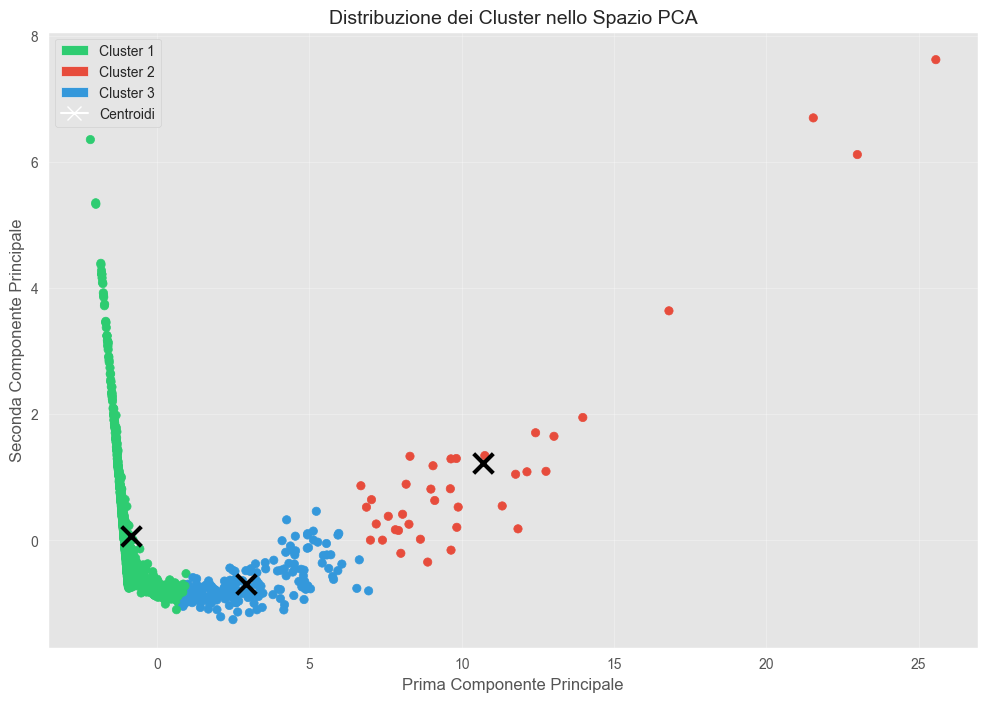

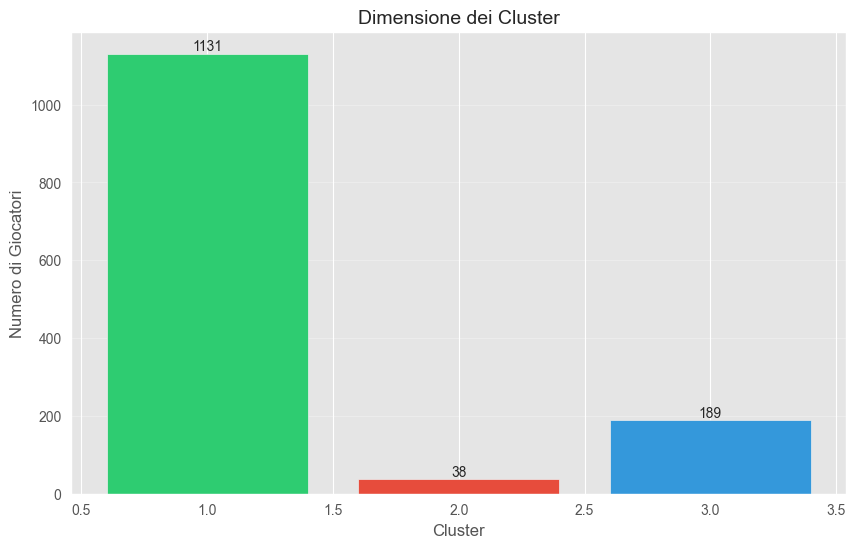

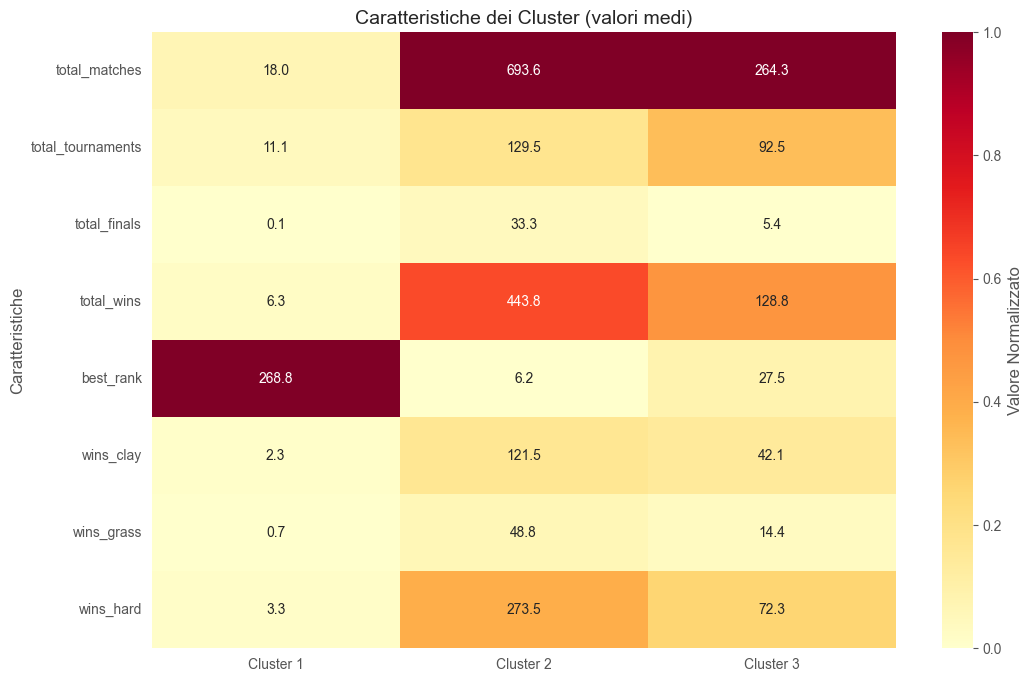

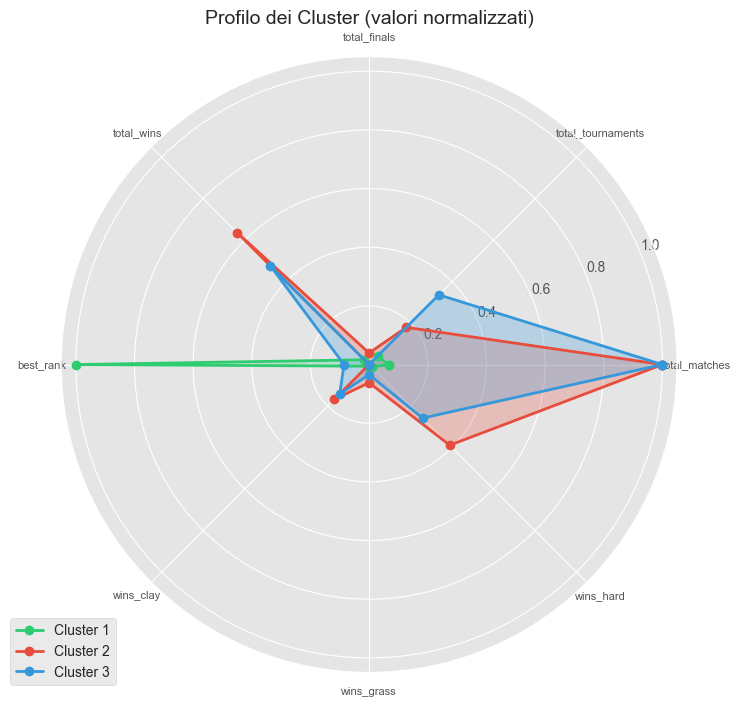

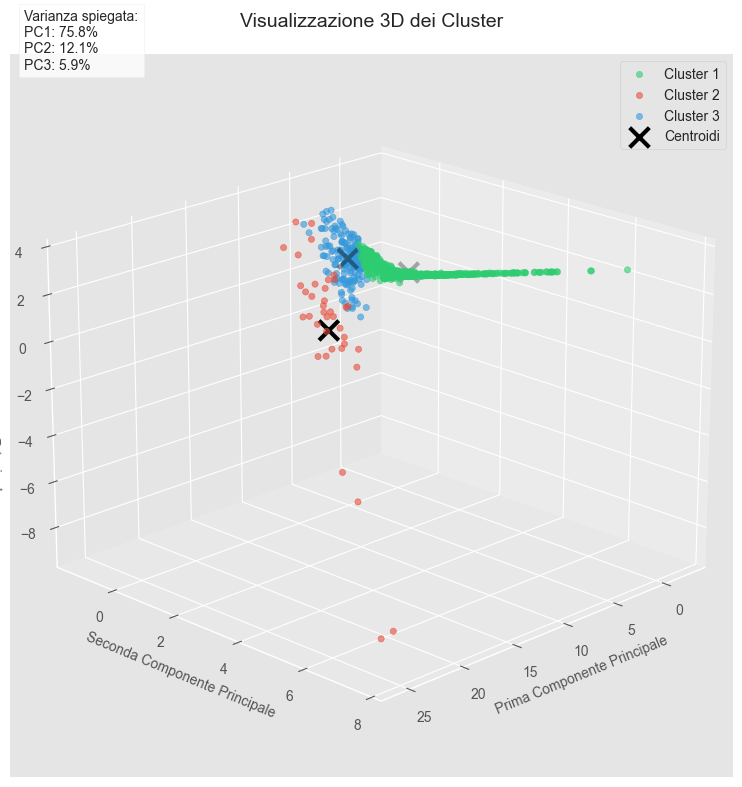


Silhouette score medio: 0.6373


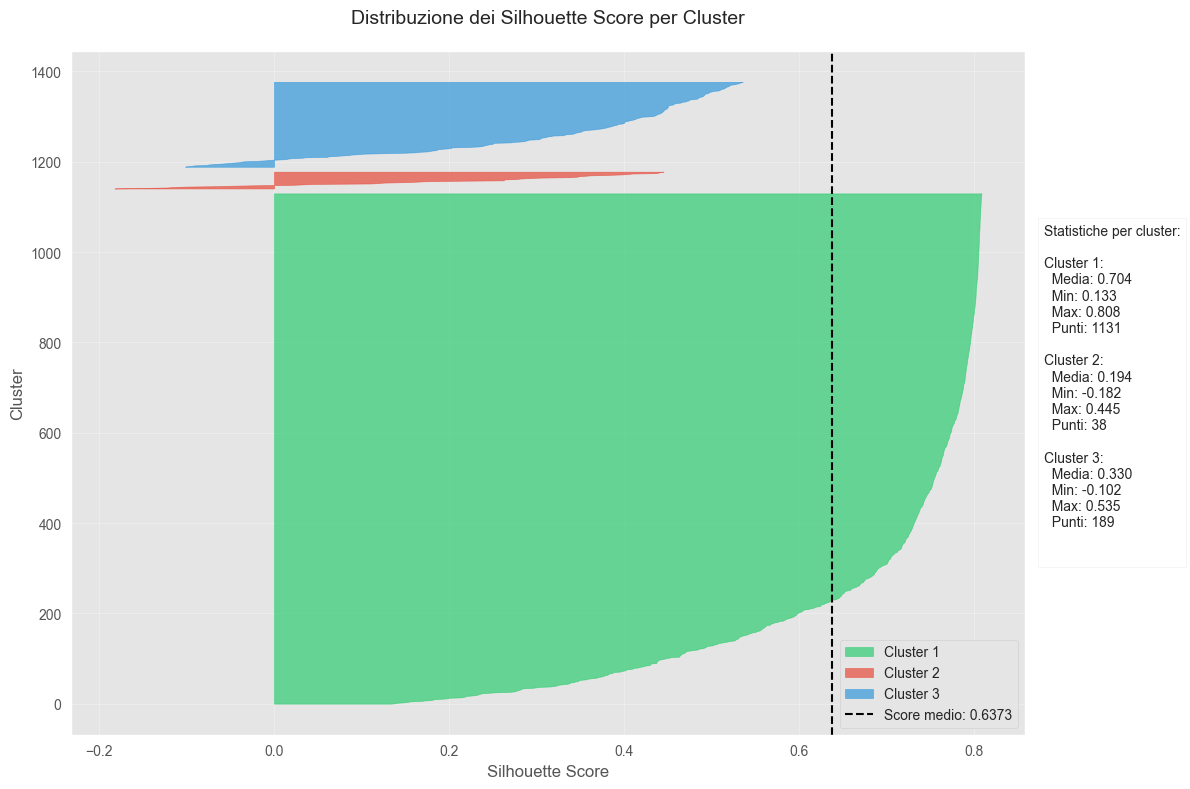


Dataset salvato come: tennis_players_clusters.csv


In [25]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Preparazione dei dati
print("Preparazione dei dati...")
features_for_pca = ['total_matches', 'total_tournaments', 'total_finals', 
                    'total_wins', 'best_rank', 'wins_clay', 'wins_grass', 'wins_hard']

# Pulizia e allineamento dei dati
df_clean = df.dropna(subset=features_for_pca)
X = df_clean[features_for_pca]

# Standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applicazione PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Applicazione K-means
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca) + 1  # Aggiungiamo 1 per partire da 1 invece che da 0

# Verifica dimensioni
print("\nVerifica dimensioni:")
print("Dimensione X_pca:", X_pca.shape)
print("Dimensione cluster_labels:", len(cluster_labels))
print("Dimensione df_clean:", df_clean.shape)

# Definiamo una palette di colori coerente per i cluster
cluster_colors = ['#2ecc71', '#e74c3c', '#3498db']  # verde, rosso, blu
plt.style.use('ggplot')

# 2. Scatter plot dei cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, 
                     cmap=ListedColormap(cluster_colors))
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
           marker='x', s=200, linewidths=3, color='black', label='Centroidi')
plt.title('Distribuzione dei Cluster nello Spazio PCA', fontsize=14)
plt.xlabel('Prima Componente Principale', fontsize=12)
plt.ylabel('Seconda Componente Principale', fontsize=12)

# Legenda personalizzata
legend_elements = [Patch(facecolor=color, label=f'Cluster {i+1}') 
                  for i, color in enumerate(cluster_colors)]
legend_elements.append(Line2D([0], [0], marker='x', color='w', markerfacecolor='black',
                            markersize=10, label='Centroidi'))
plt.legend(handles=legend_elements)
plt.grid(True, alpha=0.3)
plt.show()

# 3. Grafico a barre delle dimensioni dei cluster
plt.figure(figsize=(10, 6))
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
bars = plt.bar(range(1, k_optimal + 1), cluster_sizes, color=cluster_colors)
plt.title('Dimensione dei Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Numero di Giocatori', fontsize=12)

# Etichette sopra le barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# 4. Heatmap delle caratteristiche dei cluster
plt.figure(figsize=(12, 8))
cluster_stats = pd.DataFrame()
for i in range(k_optimal):
    cluster_stats[f'Cluster {i+1}'] = df_clean.loc[cluster_labels == i+1, features_for_pca].mean()

# Normalizzazione valori
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

# Heatmap
sns.heatmap(cluster_stats_norm, annot=cluster_stats.round(1), fmt='.1f', 
            cmap='YlOrRd', cbar_kws={'label': 'Valore Normalizzato'})
plt.title('Caratteristiche dei Cluster (valori medi)', fontsize=14)
plt.ylabel('Caratteristiche', fontsize=12)
plt.show()

# 5. Grafico radar
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='polar')

# Normalizzazione dati
stats_norm = cluster_stats_norm.T

angles = np.linspace(0, 2*np.pi, len(features_for_pca), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Chiusura del cerchio

for i in range(k_optimal):
    values = stats_norm.iloc[i].values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, 'o-', linewidth=2, color=cluster_colors[i], 
            label=f'Cluster {i+1}')
    ax.fill(angles, values, alpha=0.25, color=cluster_colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features_for_pca, size=8)
ax.set_title('Profilo dei Cluster (valori normalizzati)', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# 6. Visualizzazione 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D per ogni cluster
for i in range(k_optimal):
    cluster_mask = cluster_labels == i+1
    ax.scatter(X_pca[cluster_mask, 0], 
              X_pca[cluster_mask, 1], 
              X_pca[cluster_mask, 2],
              c=[cluster_colors[i]], 
              label=f'Cluster {i+1}',
              alpha=0.6)

# Centroidi
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
          c='black', marker='x', s=200, linewidth=3, 
          label='Centroidi')

# Personalizzazione grafico 3D
ax.set_title('Visualizzazione 3D dei Cluster', fontsize=14, pad=20)
ax.set_xlabel('Prima Componente Principale', fontsize=10)
ax.set_ylabel('Seconda Componente Principale', fontsize=10)
ax.set_zlabel('Terza Componente Principale', fontsize=10)
ax.legend()
ax.grid(True, alpha=0.3)

# Informazioni varianza spiegata
explained_variance = pca.explained_variance_ratio_[:3]
variance_text = f'Varianza spiegata:\nPC1: {explained_variance[0]:.1%}\nPC2: {explained_variance[1]:.1%}\nPC3: {explained_variance[2]:.1%}'
ax.text2D(0.02, 0.98, variance_text, transform=ax.transAxes, 
          bbox=dict(facecolor='white', alpha=0.8))

ax.view_init(elev=20, azim=45)
plt.tight_layout()
plt.show()

# 7. Analisi Silhouette
from sklearn.metrics import silhouette_samples

# Calcolo Silhouette scores
silhouette_values = silhouette_samples(X_pca, cluster_labels)
silhouette_avg = np.mean(silhouette_values)
print(f"\nSilhouette score medio: {silhouette_avg:.4f}")

# Visualizzazione Silhouette
plt.figure(figsize=(12, 8))
y_lower, y_upper = 0, 0

for i in range(k_optimal):
    cluster_silhouette_values = silhouette_values[cluster_labels == i+1]
    cluster_silhouette_values.sort()
    y_upper = y_lower + len(cluster_silhouette_values)
    
    plt.fill_betweenx(np.arange(y_lower, y_upper), 
                      0, 
                      cluster_silhouette_values,
                      alpha=0.7,
                      color=cluster_colors[i],
                      label=f"Cluster {i+1}")
    
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, 
            color="black", 
            linestyle="--", 
            label=f"Score medio: {silhouette_avg:.4f}")

plt.title("Distribuzione dei Silhouette Score per Cluster", fontsize=14, pad=20)
plt.xlabel("Silhouette Score", fontsize=12)
plt.ylabel("Cluster", fontsize=12)

# Statistiche dettagliate
stats_text = "Statistiche per cluster:\n\n"
for i in range(k_optimal):
    cluster_scores = silhouette_values[cluster_labels == i+1]
    stats_text += f"Cluster {i+1}:\n"
    stats_text += f"  Media: {np.mean(cluster_scores):.3f}\n"
    stats_text += f"  Min: {np.min(cluster_scores):.3f}\n"
    stats_text += f"  Max: {np.max(cluster_scores):.3f}\n"
    stats_text += f"  Punti: {len(cluster_scores)}\n\n"

plt.text(1.02, 0.5, stats_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='center')

plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Salviamo il DataFrame con i cluster
df_clean['cluster'] = cluster_labels
df_clean.to_csv('tennis_players_clusters.csv', index=False)
print("\nDataset salvato come: tennis_players_clusters.csv")

In [26]:
# Aggiungiamo la colonna del cluster al DataFrame originale
df_clean['cluster'] = cluster_labels

# Salviamo il DataFrame in un nuovo file CSV
output_filename = '../Datasets/New/atp_tennis_players_clustered_KMeans.csv'
df_clean.to_csv(output_filename, index=False)

print(f"\nDataset salvato come: {output_filename}")
print("\nPrime righe del nuovo dataset:")
print(df_clean.head())
print("\nDistribuzione dei cluster:")
print(df_clean['cluster'].value_counts().sort_index())


Dataset salvato come: ../Datasets/New/atp_tennis_players_clustered_KMeans.csv

Prime righe del nuovo dataset:
      Unnamed: 0  total_matches  total_tournaments  total_finals  total_wins  \
0       Hajek J.            2.0                1.0           0.0         1.0   
1     Acasuso J.          192.0               68.0           5.0       101.0   
2  Adaktusson J.            1.0                1.0           0.0         0.0   
3   Agamenone F.            5.0                2.0           0.0         3.0   
4      Agassi A.           37.0               17.0           3.0        26.0   

   best_rank  wins_clay  wins_grass  wins_hard  cluster  
0       79.0        1.0         0.0        0.0        1  
1       20.0       67.0         0.0       34.0        3  
2      265.0        0.0         0.0        0.0        1  
3      156.0        3.0         0.0        0.0        1  
4        6.0        0.0         2.0       24.0        1  

Distribuzione dei cluster:
cluster
1    1131
2      38
3   

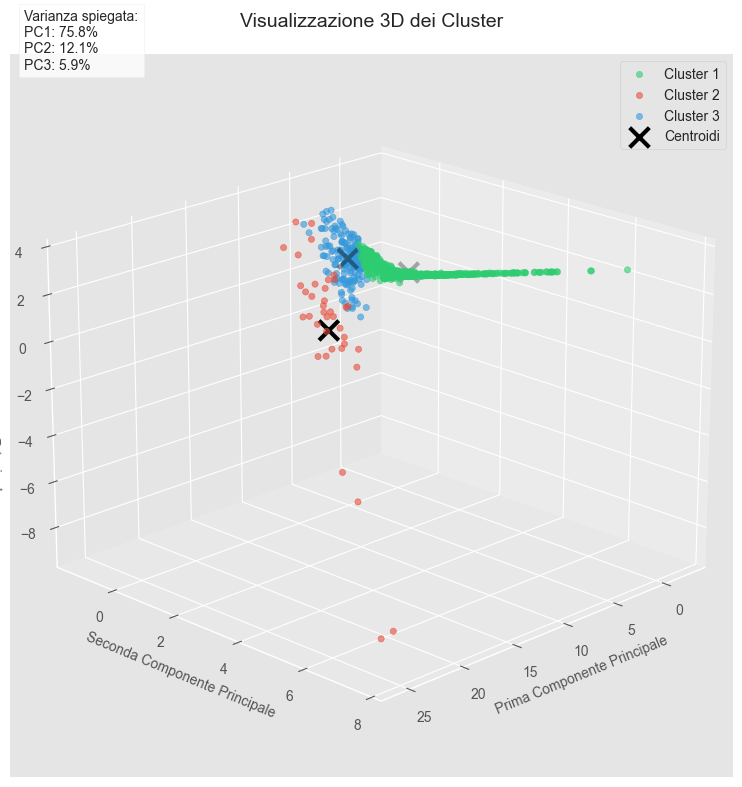

Per la visualizzazione interattiva, installa plotly con: pip install plotly


In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Creiamo il grafico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Definiamo i colori coerenti con i grafici precedenti
cluster_colors = ['#2ecc71', '#e74c3c', '#3498db']  # verde, rosso, blu

# Scatter plot 3D per ogni cluster
for i in range(k_optimal):
    cluster_mask = cluster_labels == i+1  # Modificato qui
    ax.scatter(X_pca[cluster_mask, 0], 
              X_pca[cluster_mask, 1], 
              X_pca[cluster_mask, 2],
              c=[cluster_colors[i]], 
              label=f'Cluster {i+1}',  # Modificato qui
              alpha=0.6)

# Plot dei centroidi
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
          c='black', marker='x', s=200, linewidth=3, 
          label='Centroidi')

# Personalizzazione del grafico
ax.set_title('Visualizzazione 3D dei Cluster', fontsize=14, pad=20)
ax.set_xlabel('Prima Componente Principale', fontsize=10)
ax.set_ylabel('Seconda Componente Principale', fontsize=10)
ax.set_zlabel('Terza Componente Principale', fontsize=10)

# Aggiungiamo la legenda
ax.legend()

# Aggiungiamo una griglia
ax.grid(True, alpha=0.3)

# Aggiungiamo informazioni sulla varianza spiegata
explained_variance = pca.explained_variance_ratio_[:3]
variance_text = f'Varianza spiegata:\nPC1: {explained_variance[0]:.1%}\nPC2: {explained_variance[1]:.1%}\nPC3: {explained_variance[2]:.1%}'
ax.text2D(0.02, 0.98, variance_text, transform=ax.transAxes, 
          bbox=dict(facecolor='white', alpha=0.8))

# Ruotiamo il grafico per una migliore visualizzazione
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Creiamo anche una versione interattiva con plotly (opzionale)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    
    # Creiamo un DataFrame con le prime 3 componenti principali
    df_3d = pd.DataFrame(
        X_pca[:, :3], 
        columns=['PC1', 'PC2', 'PC3']
    )
    df_3d['Cluster'] = cluster_labels  # I cluster sono già numerati da 1 a 3
    
    # Creiamo il grafico 3D interattivo
    fig = go.Figure()
    
    # Aggiungiamo i punti per ogni cluster
    for i in range(k_optimal):
        cluster_data = df_3d[df_3d['Cluster'] == i+1]  # Modificato qui
        fig.add_trace(go.Scatter3d(
            x=cluster_data['PC1'],
            y=cluster_data['PC2'],
            z=cluster_data['PC3'],
            mode='markers',
            name=f'Cluster {i+1}',  # Modificato qui
            marker=dict(
                size=5,
                color=cluster_colors[i],
                opacity=0.6
            )
        ))
    
    # Aggiungiamo i centroidi
    fig.add_trace(go.Scatter3d(
        x=centroids[:, 0],
        y=centroids[:, 1],
        z=centroids[:, 2],
        mode='markers',
        name='Centroidi',
        marker=dict(
            size=8,
            color='black',
            symbol='x'
        )
    ))
    
    # Personalizziamo il layout
    fig.update_layout(
        title='Visualizzazione 3D Interattiva dei Cluster',
        scene=dict(
            xaxis_title='Prima Componente Principale',
            yaxis_title='Seconda Componente Principale',
            zaxis_title='Terza Componente Principale'
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    fig.show()
    
except ImportError:
    print("Per la visualizzazione interattiva, installa plotly con: pip install plotly")


Silhouette score medio: 0.6373


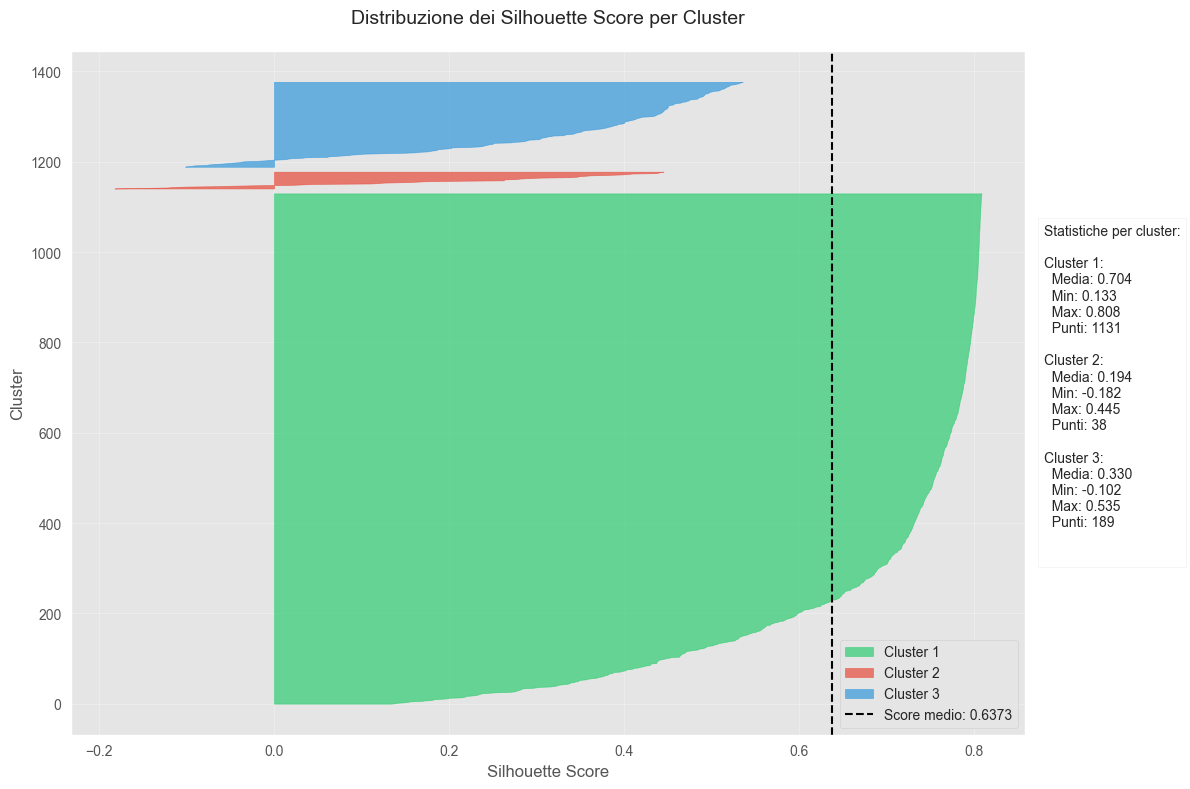


Analisi dettagliata dei Silhouette Score:
--------------------------------------------------

Cluster 1 (Colore: #2ecc71):
  Numero di punti: 1131
  Score medio: 0.704
  Score minimo: 0.133
  Score massimo: 0.808
  Deviazione standard: 0.145

Cluster 2 (Colore: #e74c3c):
  Numero di punti: 38
  Score medio: 0.194
  Score minimo: -0.182
  Score massimo: 0.445
  Deviazione standard: 0.192

Cluster 3 (Colore: #3498db):
  Numero di punti: 189
  Score medio: 0.330
  Score minimo: -0.102
  Score massimo: 0.535
  Deviazione standard: 0.176


In [28]:
from sklearn.metrics import silhouette_samples
import numpy as np
import matplotlib.pyplot as plt

# Calcoliamo i Silhouette scores per ogni punto
silhouette_values = silhouette_samples(X_pca, cluster_labels)

# Calcoliamo lo score medio
silhouette_avg = np.mean(silhouette_values)
print(f"\nSilhouette score medio: {silhouette_avg:.4f}")

# Creiamo il plot per la distribuzione dei Silhouette scores
plt.figure(figsize=(12, 8))

# Per ogni cluster, calcoliamo e plottiamo i Silhouette scores
y_lower, y_upper = 0, 0
for i in range(k_optimal):
    # Prendiamo i Silhouette scores per i punti nel cluster i+1
    cluster_silhouette_values = silhouette_values[cluster_labels == i+1]
    
    # Ordiniamo i Silhouette scores
    cluster_silhouette_values.sort()
    
    # Calcoliamo i limiti per ogni cluster
    y_upper = y_lower + len(cluster_silhouette_values)
    
    # Plottiamo i Silhouette scores per il cluster i+1
    plt.fill_betweenx(np.arange(y_lower, y_upper), 
                      0, 
                      cluster_silhouette_values,
                      alpha=0.7,
                      color=cluster_colors[i],
                      label=f"Cluster {i+1}")
    
    # Aggiorniamo il limite inferiore per il prossimo cluster
    y_lower = y_upper + 10

# Aggiungiamo una linea verticale per lo score medio
plt.axvline(x=silhouette_avg, 
            color="black", 
            linestyle="--", 
            label=f"Score medio: {silhouette_avg:.4f}")

# Personalizziamo il grafico
plt.title("Distribuzione dei Silhouette Score per Cluster", fontsize=14, pad=20)
plt.xlabel("Silhouette Score", fontsize=12)
plt.ylabel("Cluster", fontsize=12)

# Aggiungiamo statistiche dettagliate in un box
stats_text = "Statistiche per cluster:\n\n"
for i in range(k_optimal):
    cluster_scores = silhouette_values[cluster_labels == i+1]
    stats_text += f"Cluster {i+1}:\n"
    stats_text += f"  Media: {np.mean(cluster_scores):.3f}\n"
    stats_text += f"  Min: {np.min(cluster_scores):.3f}\n"
    stats_text += f"  Max: {np.max(cluster_scores):.3f}\n"
    stats_text += f"  Punti: {len(cluster_scores)}\n\n"

plt.text(1.02, 0.5, stats_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='center')

plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Stampa analisi dettagliata
print("\nAnalisi dettagliata dei Silhouette Score:")
print("-" * 50)
for i in range(k_optimal):
    cluster_scores = silhouette_values[cluster_labels == i+1]
    print(f"\nCluster {i+1} (Colore: {cluster_colors[i]}):")
    print(f"  Numero di punti: {len(cluster_scores)}")
    print(f"  Score medio: {np.mean(cluster_scores):.3f}")
    print(f"  Score minimo: {np.min(cluster_scores):.3f}")
    print(f"  Score massimo: {np.max(cluster_scores):.3f}")
    print(f"  Deviazione standard: {np.std(cluster_scores):.3f}")

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator  # Aggiungiamo questa importazione
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Iniziando l'analisi con DBSCAN...")

# 1. Preparazione dei dati (usando i dati già scalati e ridotti con PCA)
print("\n1. Utilizzo dei dati pre-processati con PCA...")
X = X_pca  # usiamo i dati già processati con PCA

ModuleNotFoundError: No module named 'kneed'


2. Calcolo della distanza ottimale (eps)...


NameError: name 'KneeLocator' is not defined

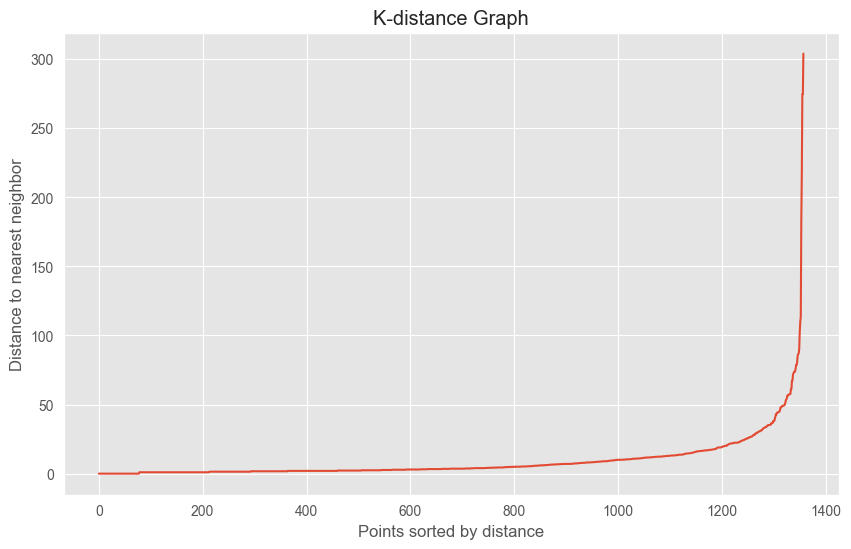

In [30]:
# 2. Trovare il valore ottimale di eps
print("\n2. Calcolo della distanza ottimale (eps)...")
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 1])

# Visualizzazione del grafico delle distanze
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.title('K-distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to nearest neighbor')
plt.grid(True)

# Trova il punto di gomito
knee_locator = KneeLocator(range(len(distances)), 
                          distances, 
                          curve='convex', 
                          direction='increasing')
elbow_point = knee_locator.elbow
eps_value = distances[elbow_point]

plt.axhline(y=eps_value, color='r', linestyle='--', 
            label=f'Optimal eps = {eps_value:.3f}')
plt.legend()
plt.show()

print(f"\nValore ottimale di eps trovato: {eps_value:.3f}")

In [31]:
# 3. Applicazione di DBSCAN con diversi parametri
print("\n3. Applicazione di DBSCAN con diversi parametri...")
eps_range = [eps_value * 0.5, eps_value, eps_value * 1.5, eps_value * 2]
min_samples_range = [3, 5, 7, 10]

results = []
for eps in eps_range:
    for min_samples in min_samples_range:
        print(f"\nTestando eps={eps:.3f}, min_samples={min_samples}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X)
        
        # Numero di cluster (escludendo il rumore)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(X),
            'labels': cluster_labels
        })
        
        print(f"Numero di cluster trovati: {n_clusters}")
        print(f"Punti di rumore: {n_noise} ({n_noise/len(X)*100:.1f}%)")


3. Applicazione di DBSCAN con diversi parametri...


NameError: name 'eps_value' is not defined

In [32]:
# 4. Selezione dei migliori parametri
print("\n4. Analisi dei risultati...")
for r in results:
    print(f"\neps={r['eps']:.3f}, min_samples={r['min_samples']}:")
    print(f"  Clusters: {r['n_clusters']}")
    print(f"  Noise: {r['noise_ratio']*100:.1f}%")


4. Analisi dei risultati...


NameError: name 'results' is not defined

In [33]:
# Ordiniamo i risultati
sorted_results = sorted(results, key=lambda x: (x['noise_ratio'], -x['n_clusters']))

print("Risultati ordinati per rumore crescente e numero di cluster decrescente:")
for r in sorted_results:
    print(f"\neps={r['eps']:.3f}, min_samples={r['min_samples']}:")
    print(f"  Clusters: {r['n_clusters']}")
    print(f"  Noise: {r['noise_ratio']*100:.1f}%")

# Filtriamo i risultati migliori
good_results = [r for r in results 
                if 0.01 <= r['noise_ratio'] <= 0.10  # 1-10% di rumore
                and 2 <= r['n_clusters'] <= 5]       # 2-5 cluster

print("\nMigliori combinazioni di parametri:")
for r in good_results:
    print(f"\neps={r['eps']:.3f}, min_samples={r['min_samples']}:")
    print(f"  Clusters: {r['n_clusters']}")
    print(f"  Noise: {r['noise_ratio']*100:.1f}%")

NameError: name 'results' is not defined


5. Visualizzazione dei risultati finali...
Risultati disponibili:
Indice 0: eps=0.938, min_samples=3
Indice 1: eps=0.938, min_samples=5
Indice 2: eps=0.938, min_samples=7
Indice 3: eps=0.938, min_samples=10
Indice 4: eps=1.876, min_samples=3
Indice 5: eps=1.876, min_samples=5
Indice 6: eps=1.876, min_samples=7
Indice 7: eps=1.876, min_samples=10
Indice 8: eps=2.815, min_samples=3
Indice 9: eps=2.815, min_samples=5
Indice 10: eps=2.815, min_samples=7
Indice 11: eps=2.815, min_samples=10
Indice 12: eps=3.753, min_samples=3
Indice 13: eps=3.753, min_samples=5
Indice 14: eps=3.753, min_samples=7
Indice 15: eps=3.753, min_samples=10

Parametri selezionati:
eps=1.876, min_samples=3
Numero di cluster: 4
Percentuale di rumore: 1.4%


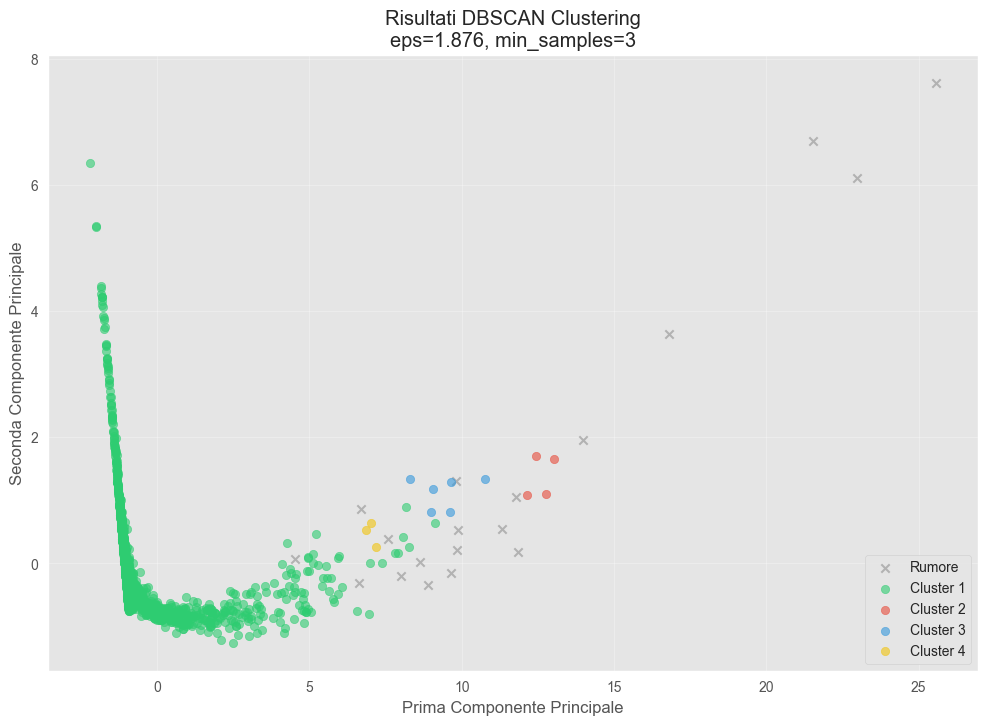

In [259]:
print("\n5. Visualizzazione dei risultati finali...")

# Troviamo l'indice del risultato migliore
target_eps = 1.876
target_min_samples = 3

# Stampa dei risultati per debug
print("Risultati disponibili:")
for i, r in enumerate(results):
    print(f"Indice {i}: eps={r['eps']:.3f}, min_samples={r['min_samples']}")

# Troviamo il risultato più vicino ai valori target
best_index = min(range(len(results)), 
                key=lambda i: abs(results[i]['eps'] - target_eps) + 
                            abs(results[i]['min_samples'] - target_min_samples))

best_result = results[best_index]
best_labels = best_result['labels']

# Rinumeriamo i cluster partendo da 1 (escludendo il rumore che è -1)
unique_labels = sorted(list(set(best_labels)))
if -1 in unique_labels:
    unique_labels.remove(-1)
label_map = {old_label: new_label + 1 for new_label, old_label in enumerate(unique_labels)}
label_map[-1] = -1  # manteniamo -1 per il rumore

# Applichiamo la nuova numerazione
new_labels = np.array([label_map[label] for label in best_labels])

print(f"\nParametri selezionati:")
print(f"eps={best_result['eps']:.3f}, min_samples={best_result['min_samples']}")
print(f"Numero di cluster: {best_result['n_clusters']}")
print(f"Percentuale di rumore: {best_result['noise_ratio']*100:.1f}%")

# Visualizzazione 2D
plt.figure(figsize=(12, 8))

# Definiamo colori consistenti
cluster_colors = ['#2ecc71', '#e74c3c', '#3498db', '#f1c40f', '#9b59b6']  # verde, rosso, blu, giallo, viola

# Scatter plot dei punti di rumore
noise_mask = new_labels == -1
plt.scatter(X[noise_mask, 0], X[noise_mask, 1], 
           c='gray', marker='x', label='Rumore', alpha=0.5)

# Scatter plot dei cluster
for i, label in enumerate(range(1, max(new_labels) + 1)):
    mask = new_labels == label
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=[cluster_colors[i]], label=f'Cluster {label}', alpha=0.6)

plt.title(f'Risultati DBSCAN Clustering\neps={best_result["eps"]:.3f}, '
          f'min_samples={best_result["min_samples"]}')
plt.xlabel('Prima Componente Principale')
plt.ylabel('Seconda Componente Principale')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

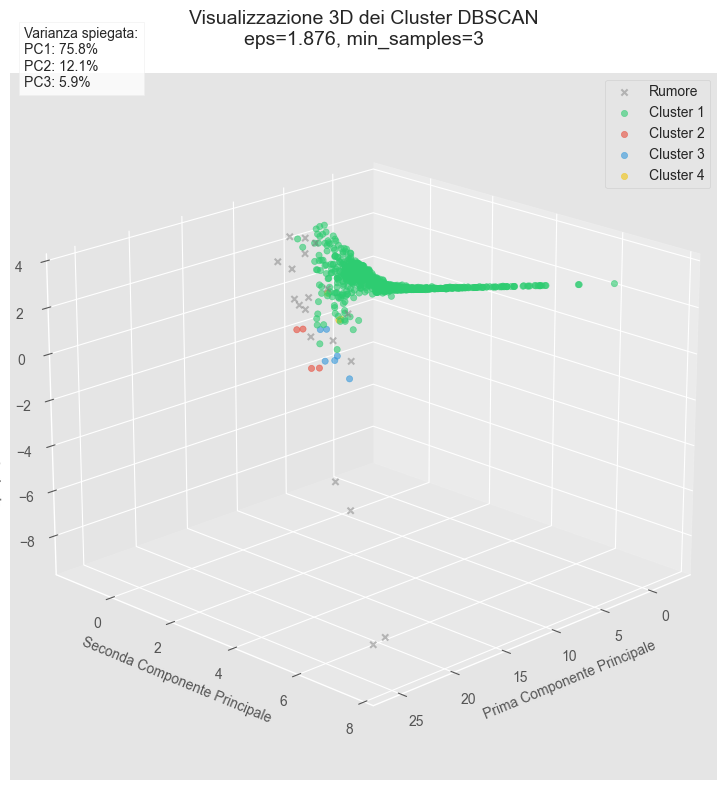

In [260]:
# Visualizzazione 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Definiamo gli stessi colori usati prima per consistenza
cluster_colors = ['#2ecc71', '#e74c3c', '#3498db', '#f1c40f', '#9b59b6']  # verde, rosso, blu, giallo, viola

# Plot dei punti di rumore
noise_mask = new_labels == -1
ax.scatter(X[noise_mask, 0], 
          X[noise_mask, 1], 
          X[noise_mask, 2],
          c='gray', marker='x', label='Rumore', alpha=0.5)

# Plot dei cluster
for i, label in enumerate(range(1, max(new_labels) + 1)):
    mask = new_labels == label
    ax.scatter(X[mask, 0], 
              X[mask, 1], 
              X[mask, 2],
              c=[cluster_colors[i]], 
              label=f'Cluster {label}',
              alpha=0.6)

# Personalizzazione del grafico
ax.set_title('Visualizzazione 3D dei Cluster DBSCAN\n' + 
             f'eps={best_result["eps"]:.3f}, min_samples={best_result["min_samples"]}',
             fontsize=14, pad=20)
ax.set_xlabel('Prima Componente Principale', fontsize=10)
ax.set_ylabel('Seconda Componente Principale', fontsize=10)
ax.set_zlabel('Terza Componente Principale', fontsize=10)

# Aggiungiamo la legenda
ax.legend()

# Aggiungiamo una griglia
ax.grid(True, alpha=0.3)

# Aggiungiamo informazioni sulla varianza spiegata
explained_variance = pca.explained_variance_ratio_[:3]
variance_text = f'Varianza spiegata:\nPC1: {explained_variance[0]:.1%}\nPC2: {explained_variance[1]:.1%}\nPC3: {explained_variance[2]:.1%}'
ax.text2D(0.02, 0.98, variance_text, transform=ax.transAxes, 
          bbox=dict(facecolor='white', alpha=0.8))

# Ruotiamo il grafico per una migliore visualizzazione
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

# Versione interattiva con plotly (opzionale)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    
    # Creiamo un DataFrame con le prime 3 componenti principali
    df_3d = pd.DataFrame(
        X[:, :3], 
        columns=['PC1', 'PC2', 'PC3']
    )
    df_3d['Cluster'] = new_labels
    
    # Creiamo il grafico 3D interattivo
    fig = go.Figure()
    
    # Aggiungiamo i punti di rumore
    noise_data = df_3d[df_3d['Cluster'] == -1]
    if len(noise_data) > 0:
        fig.add_trace(go.Scatter3d(
            x=noise_data['PC1'],
            y=noise_data['PC2'],
            z=noise_data['PC3'],
            mode='markers',
            name='Rumore',
            marker=dict(
                size=5,
                color='gray',
                symbol='x',
                opacity=0.5
            )
        ))
    
    # Aggiungiamo i punti per ogni cluster
    for i, label in enumerate(range(1, max(new_labels) + 1)):
        cluster_data = df_3d[df_3d['Cluster'] == label]
        fig.add_trace(go.Scatter3d(
            x=cluster_data['PC1'],
            y=cluster_data['PC2'],
            z=cluster_data['PC3'],
            mode='markers',
            name=f'Cluster {label}',
            marker=dict(
                size=5,
                color=cluster_colors[i],
                opacity=0.6
            )
        ))
    
    # Personalizziamo il layout
    fig.update_layout(
        title='Visualizzazione 3D Interattiva dei Cluster DBSCAN',
        scene=dict(
            xaxis_title='Prima Componente Principale',
            yaxis_title='Seconda Componente Principale',
            zaxis_title='Terza Componente Principale'
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )
    
    fig.show()
    
except ImportError:
    print("Per la visualizzazione interattiva, installa plotly con: pip install plotly")

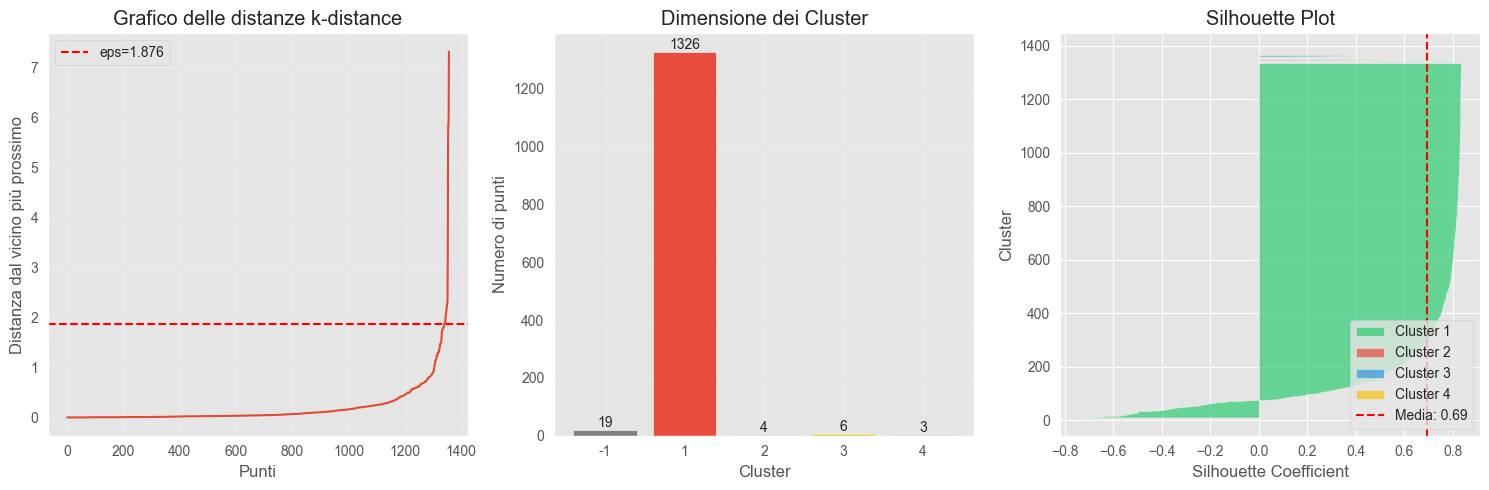

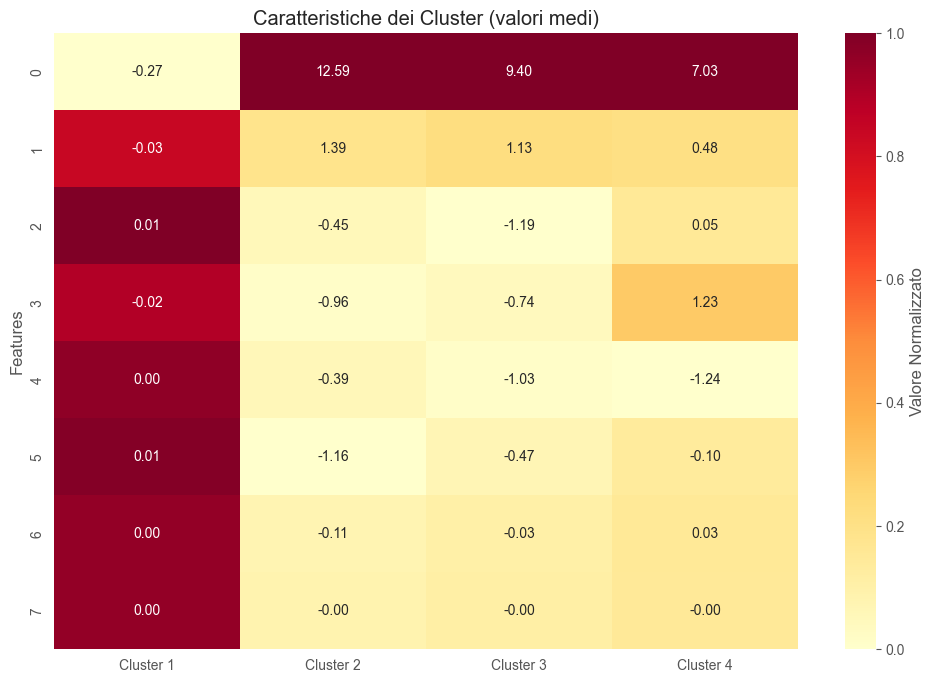

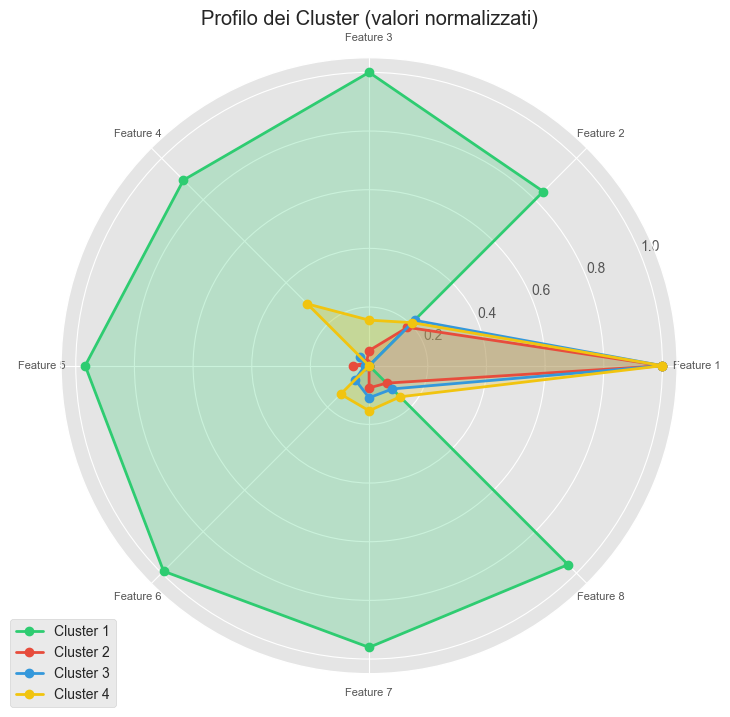


Statistiche dettagliate per cluster:
--------------------------------------------------

Cluster 1:
Numero di punti: 1326
Caratteristiche medie:
  Feature 1: -0.27
  Feature 2: -0.03
  Feature 3: 0.01
  Feature 4: -0.02
  Feature 5: 0.00
  Feature 6: 0.01
  Feature 7: 0.00
  Feature 8: 0.00

Cluster 2:
Numero di punti: 4
Caratteristiche medie:
  Feature 1: 12.59
  Feature 2: 1.39
  Feature 3: -0.45
  Feature 4: -0.96
  Feature 5: -0.39
  Feature 6: -1.16
  Feature 7: -0.11
  Feature 8: -0.00

Cluster 3:
Numero di punti: 6
Caratteristiche medie:
  Feature 1: 9.40
  Feature 2: 1.13
  Feature 3: -1.19
  Feature 4: -0.74
  Feature 5: -1.03
  Feature 6: -0.47
  Feature 7: -0.03
  Feature 8: -0.00

Cluster 4:
Numero di punti: 3
Caratteristiche medie:
  Feature 1: 7.03
  Feature 2: 0.48
  Feature 3: 0.05
  Feature 4: 1.23
  Feature 5: -1.24
  Feature 6: -0.10
  Feature 7: 0.03
  Feature 8: -0.00


In [261]:
# 1. Distribuzione della densità dei punti
plt.figure(figsize=(15, 5))

# Plot 1: Distribuzione delle distanze dal punto più vicino
plt.subplot(131)
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(X)
distances, _ = neigh.kneighbors(X)
distances = np.sort(distances[:, 1])

plt.plot(distances)
plt.axhline(y=best_result['eps'], color='r', linestyle='--', 
           label=f"eps={best_result['eps']:.3f}")
plt.title('Grafico delle distanze k-distance')
plt.xlabel('Punti')
plt.ylabel('Distanza dal vicino più prossimo')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Dimensione dei cluster
plt.subplot(132)
cluster_sizes = pd.Series(new_labels).value_counts().sort_index()
colors = ['gray' if idx == -1 else cluster_colors[i] 
          for i, idx in enumerate(cluster_sizes.index)]
bars = plt.bar(cluster_sizes.index.astype(str), cluster_sizes, color=colors)
plt.title('Dimensione dei Cluster')
plt.xlabel('Cluster')
plt.ylabel('Numero di punti')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Plot 3: Silhouette plot
plt.subplot(133)
from sklearn.metrics import silhouette_samples, silhouette_score

# Calcoliamo i silhouette scores escludendo i punti di rumore
mask_no_noise = new_labels != -1
if len(set(new_labels[mask_no_noise])) > 1:  # verifichiamo che ci siano almeno 2 cluster
    silhouette_avg = silhouette_score(X[mask_no_noise], new_labels[mask_no_noise])
    silhouette_values = silhouette_samples(X[mask_no_noise], new_labels[mask_no_noise])
    
    y_lower = 10
    for i in range(1, max(new_labels) + 1):
        cluster_silhouette_values = silhouette_values[new_labels[mask_no_noise] == i]
        cluster_silhouette_values.sort()
        
        size_cluster_i = len(cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i
        
        color = cluster_colors[i-1]
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_values,
                         facecolor=color, alpha=0.7,
                         label=f'Cluster {i}')
        
        y_lower = y_upper + 10
        
    plt.axvline(x=silhouette_avg, color="red", linestyle="--",
                label=f'Media: {silhouette_avg:.2f}')
    
    plt.title('Silhouette Plot')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.legend(loc='lower right')
else:
    plt.text(0.5, 0.5, 'Necessari almeno 2 cluster\nper il Silhouette plot',
             ha='center', va='center')

plt.tight_layout()
plt.show()

# 4. Heatmap delle caratteristiche per cluster
plt.figure(figsize=(12, 8))
cluster_stats = pd.DataFrame()

# Calcoliamo le medie delle features per ogni cluster
for label in range(1, max(new_labels) + 1):
    mask = new_labels == label
    cluster_stats[f'Cluster {label}'] = X[mask].mean(axis=0)

# Normalizziamo i valori
cluster_stats_norm = (cluster_stats - cluster_stats.min()) / (cluster_stats.max() - cluster_stats.min())

# Creiamo la heatmap
sns.heatmap(cluster_stats_norm, annot=cluster_stats.round(2), fmt='.2f',
            cmap='YlOrRd', cbar_kws={'label': 'Valore Normalizzato'})
plt.title('Caratteristiche dei Cluster (valori medi)')
plt.ylabel('Features')
plt.show()

# 5. Grafico radar delle caratteristiche
plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection='polar')

# Preparazione dati per il grafico radar
angles = np.linspace(0, 2*np.pi, X.shape[1], endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Chiude il cerchio

for i in range(cluster_stats.shape[1]):
    values = cluster_stats_norm.iloc[:, i].values
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, 'o-', linewidth=2, color=cluster_colors[i], 
            label=f'Cluster {i+1}')
    ax.fill(angles, values, alpha=0.25, color=cluster_colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'Feature {i+1}' for i in range(X.shape[1])], size=8)
ax.set_title('Profilo dei Cluster (valori normalizzati)')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

# Stampa statistiche dettagliate
print("\nStatistiche dettagliate per cluster:")
print("-" * 50)
for label in range(1, max(new_labels) + 1):
    mask = new_labels == label
    print(f"\nCluster {label}:")
    print(f"Numero di punti: {np.sum(mask)}")
    print("Caratteristiche medie:")
    for i, mean_val in enumerate(X[mask].mean(axis=0)):
        print(f"  Feature {i+1}: {mean_val:.2f}")

In [264]:
# Aggiungiamo la colonna del cluster al DataFrame originale
df_clean['cluster'] = new_labels

# Analizziamo le caratteristiche di ogni cluster per assegnare descrizioni appropriate
cluster_stats = pd.DataFrame()
for i in range(1, max(new_labels) + 1):
    cluster_stats[f'Cluster {i}'] = df_clean[df_clean['cluster'] == i][features_for_pca].mean()

print("\nCaratteristiche medie per cluster:")
print(cluster_stats)

# Creiamo un dizionario per le descrizioni dei cluster
cluster_descriptions = {}

# Per i punti di rumore
cluster_descriptions[-1] = 'Outlier'

# Per ogni cluster, analizziamo le caratteristiche dominanti
for i in range(1, max(new_labels) + 1):
    cluster_values = cluster_stats[f'Cluster {i}']
    
    # Troviamo le caratteristiche più significative
    top_features = cluster_values.nlargest(3)
    print(f"\nCaratteristiche principali del Cluster {i}:")
    for feat, val in top_features.items():
        print(f"- {feat}: {val:.2f}")
    
    # Assegniamo una descrizione basata sulle caratteristiche
    if cluster_values['total_wins'] > cluster_stats.loc['total_wins'].mean():
        if cluster_values['best_rank'] < cluster_stats.loc['best_rank'].mean():
            cluster_descriptions[i] = 'Top Players'
        else:
            cluster_descriptions[i] = 'High Performance Players'
    elif cluster_values['total_matches'] > cluster_stats.loc['total_matches'].mean():
        cluster_descriptions[i] = 'Experienced Players'
    else:
        cluster_descriptions[i] = 'Developing Players'

# Aggiungiamo la colonna con le descrizioni
df_clean['cluster_description'] = df_clean['cluster'].map(cluster_descriptions)

# Salviamo il DataFrame in un nuovo file CSV
output_filename = '../Datasets/New/atp_tennis_players_clustered_DBScan.csv'
df_clean.to_csv(output_filename, index=False)

print(f"\nDataset salvato come: {output_filename}")
print("\nDistribuzione dei cluster:")
print(df_clean['cluster_description'].value_counts())
print("\nPrime righe del nuovo dataset:")
print(df_clean[['cluster', 'cluster_description']].head(10))

# Stampiamo anche alcune statistiche per cluster
print("\nStatistiche dettagliate per cluster:")
for i in range(1, max(new_labels) + 1):
    print(f"\nCluster {i} - {cluster_descriptions[i]}:")
    print(cluster_stats[f'Cluster {i}'].round(2))


Caratteristiche medie per cluster:
                    Cluster 1  Cluster 2   Cluster 3   Cluster 4
total_matches       55.969080     838.50  618.833333  487.000000
total_tournaments   23.276018     151.75  112.000000  101.000000
total_finals         0.961538      31.75   29.666667   25.000000
total_wins          25.345400     533.25  410.000000  317.000000
best_rank          233.209653       5.00    4.166667    3.666667
wins_clay            8.076923     124.00   75.000000   97.333333
wins_grass           2.941931      60.50   43.000000   16.333333
wins_hard           14.326546     348.75  292.000000  203.333333

Caratteristiche principali del Cluster 1:
- best_rank: 233.21
- total_matches: 55.97
- total_wins: 25.35

Caratteristiche principali del Cluster 2:
- total_matches: 838.50
- total_wins: 533.25
- wins_hard: 348.75

Caratteristiche principali del Cluster 3:
- total_matches: 618.83
- total_wins: 410.00
- wins_hard: 292.00

Caratteristiche principali del Cluster 4:
- total_matche